# Группа: DST-48
**Sergey Pinaev - binom1982@gmail.com**
# Проект №5. Выбираем авто
Ссылка на соревнование: [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction)
<!--<img src="https://media.istockphoto.com/vectors/goal-vector-id1010565316?k=6&m=1010565316&s=612x612&w=0&h=xZ3TLL6nOc_eTcn58HKgkW7GMbkA-lYksGQHomGTOhM="/>-->
<p align="center" width="100%">
<img src="https://thumbs.dreamstime.com/b/choosing-car-confused-man-decides-what-to-choose-94260361.jpg" width="400"/>
</p>
<hr>

# Task
Представьте, что вы работаете в компании, которая занимается продажей автомобилей с пробегом. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).

Вам поставлена задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.
Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

Так исторически сложилось, что компания изначально не собирала данные. Есть только небольшой датасет с историей продаж, которого для обучения модели будет явно мало. Его мы будем использовать для теста (В ЛидерБорде), остальное придется собрать самим…

# Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import re
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE # Рекурсивное устранение признаков (RFE)

from bs4 import BeautifulSoup 
import requests 
from pprint import pprint  

# import datetime, time
from datetime import timedelta, datetime, date, time


from time import sleep
from tqdm.notebook import tqdm, tqdm_notebook
import json


# Подключаем форматирование Markdown
from IPython.display import Markdown

from matplotlib.ticker import PercentFormatter

# дополнительные настройки
pd.set_option('display.max_columns', None)
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# отключим warnings, чтобы они нам не мешали
# import warnings
# warnings.filterwarnings('ignore')

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [2]:
# Фиксируем RANDOM_SEED, чтобы эксперимент был воспроизводим
RANDOM_SEED = 42

# Parsing avto.ru
В другом ноутбуке приложенному к проекту написан код для парсинга **avto.ru**.

Были спарсины все объявления всех брендов на **19 июля 2021**.

# Data Description:
1. **bodyType** - тип автомобиля
1. **brand** - название бренда
1. **car_url** - url объявления
1. **color** - цвет автомобиля
1. **complectation_dict** - словарь комплектации автомобиля
1. **description** - текстовое описание продавца
1. **engineDisplacement** - объем двигателя
1. **enginePower** - мощность двигателя
1. **equipment_dict** - словарь оборудования автомобиля
1. **fuelType** - тип топлива
1. **image** - url изображения автомобиля
1. **mileage** - пробег
1. **modelDate** - год выпуска модели
1. **model_info** - словарь информации об автомобиле
1. **model_name** - тип модели
1. **name** - харакетиристика конкретной модели
1. **numberOfDoors** - количество дверей
1. **parsing_unixtime** - дата парсинга данных
1. **priceCurrency** - тип валюты
1. **productionDate** - год производства автомобиля
1. **sell_id** - номер объявления
1. **super_gen** - словарь характеристик текущего поколения автомобиля
1. **vehicleConfiguration** - конфигурация автомобиля
1. **vehicleTransmission** - тип трансмиссии
1. **vendor** - регион производства автомобиля
1. **Владельцы** - количество владельцев
1. **Владение** - срок владения продавцом автомобиля
1. **ПТС** - флаг наличия ПТС
1. **Привод** - тип привода
1. **Руль** - тип рулья
1. **Состояние** - состояния автомобиля
1. **Таможня** -  флаг растаможки
1. **price** - цена

# Data

In [3]:
%time 
is_kaggle_or_github = False # в зависимости от использования kaggle или github, задается соответствующий путь к датасетам

if is_kaggle_or_github:
    DIR_TRAIN  = '../input/all-announcement-info/' # мой тренировочный датасет
    DIR_TEST   = '../input/sf-dst-car-price-prediction/'
else: 
    DIR_TRAIN  = 'data/'
    DIR_TEST   = 'data/'

df_train = pd.read_csv(DIR_TRAIN + '20210719_all_announcement_info_theard.csv' , encoding="cp1251", sep=";")
df_test = pd.read_csv(DIR_TEST + 'test.csv')

sample_submission = df_test.loc[:,['sell_id']]
sample_submission['price'] = -1

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs


In [4]:
display(df_train.head(1).T)
display(df_test.head(1).T)

,0
bodyType,внедорожник 5 дв.
brand,Nissan
car_url,https://auto.ru/cars/used/sale/nissan/terrano/...
color,чёрный
complectation_dict,{'id': '0'}
description,АВТОМОБИЛЬ ПОДГОТОВЛЕН К ПРОДАЖЕ И ГОТОВ К ДАЛ...
engineDisplacement,2.0 LTR
enginePower,143 N12
equipment_dict,{}
fuelType,бензин


,0
bodyType,лифтбек
brand,SKODA
car_url,https://auto.ru/cars/used/sale/skoda/octavia/1...
color,синий
complectation_dict,NaN
description,"Все автомобили, представленные в продаже, прох..."
engineDisplacement,1.2 LTR
enginePower,105 N12
equipment_dict,"{""engine-proof"":true,""tinted-glass"":true,""airb..."
fuelType,бензин


In [5]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233128 entries, 0 to 233127
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              233128 non-null  object 
 1   brand                 233128 non-null  object 
 2   car_url               233128 non-null  object 
 3   color                 233128 non-null  object 
 4   complectation_dict    225082 non-null  object 
 5   description           233128 non-null  object 
 6   engineDisplacement    233128 non-null  object 
 7   enginePower           233128 non-null  object 
 8   equipment_dict        233128 non-null  object 
 9   fuelType              233128 non-null  object 
 10  image                 231483 non-null  object 
 11  mileage               233128 non-null  int64  
 12  modelDate             233128 non-null  float64
 13  model_info            233128 non-null  object 
 14  model_name            233128 non-null  object 
 15  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

None

# Functions

In [6]:
def mape(y_true, y_pred):
    '''Метрика -средний абсолютный процент ошибки'''  
    return np.mean(np.abs((y_pred-y_true)/y_true))


def top_freq_value(series, delimiter=' ', dropna=True, top=0):
    '''Выводит статистику самых встречающихся значений в столбце'''
    value_series = series.value_counts(dropna=dropna)
    
    symbol_limit = 20
    value_list = [f'{str(index)[:symbol_limit]+"..." if len(str(index)) >= symbol_limit else index} - {value}' for index, value in value_series.items()]
    
    if top == 0:
        return delimiter.join(value_list)
    else:
        return delimiter.join(value_list[0:top])

        
def dataset_custom_description(dataset, top=0):
    '''Выводит дополнительную информацию о датасете'''

    count_any_null = dataset[dataset.isnull().any(1)].shape[0]
    count_not_any_null = dataset.shape[0] - count_any_null
    types_info = "<br>".join([f'{index} ({value})' for index, value in dataset.dtypes.value_counts().items()])

    display(Markdown(f'## Общая информация'))
    display(Markdown(f'''| Характеристика   |      Значение      |
                        |:----------|:-------------|
                        |**количество (строк, столбцов):**|({dataset.shape[0]}, {dataset.shape[1]})|\n|**количество строк (ни одного пустого значения):**|{count_not_any_null}|\n|**количество строк (хотябы одно пустое значение):**|{count_any_null}|\n|**распределение типов столбцов:**|{types_info}|
                        '''))

    # формируем более информативную таблицу о датасете
    display(Markdown(f'## Информация о столбцах'))
    data = {'name': [], 'type': [], 'non_null': [], 'null': [], 'null_mean': [],
            'unique': [], 'mean': [], 'std': [], 'min': [], 
            '25%': [], '50%': [], '75%': [], 'max': [], 'distribution (10 first values)': []}

    for column_name, column_type in dataset.dtypes.items():
        column_series = dataset[column_name]
        
        data['name'].append(column_name)
        data['type'].append(str(column_type))
        data['non_null'].append(column_series.count())
        data['null'].append(column_series.isna().sum())
        data['null_mean'].append(f'{column_series.isna().mean() :.1%}')
        data['unique'].append(column_series.nunique())
       
        data['mean'].append(f'{column_series.mean() :.2f}' if column_series.dtype != 'object' else '')
        data['std'].append(f'{column_series.std() :.2f}' if column_series.dtype != 'object' else '')

        data['min'].append(column_series.min() if column_series.dtype != 'object' else '')
        data['25%'].append(column_series.quantile(0.25) if column_series.dtype != 'object' else '')
        data['50%'].append(column_series.quantile(0.5) if column_series.dtype != 'object' else '')
        data['75%'].append(column_series.quantile(0.75) if column_series.dtype != 'object' else '')
        data['max'].append(column_series.max() if column_series.dtype != 'object' else '')
        
        data['distribution (10 first values)'].append(top_freq_value(column_series, ' | ', False, top))
        
    data = pd.DataFrame(data=data)
    #data = data.style.highlight_max(axis=0)

    with pd.option_context('display.max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None):
        display(data)


def get_emission_limits(data_series):
    '''
    Возвращает кортеж границ выбросов вычесленных на основе межвартильного размаха и 1 и 99 перцентиль.
    При необходимости данные выходящие за нижнюю и верхнюю границу можно не удалять а присваивать им значение  1 и 99 перцентиля.
    df.loc[df['column'] < min_emission_limits, 'column'] = perc01
    df.loc[df['column'] > max_emission_limits, 'column'] = perc99
    '''
    perc25, perc75 = np.percentile(data_series,[25,75])
    perc1, perc99 = np.percentile(data_series,[1,99])
    IQR = perc75 - perc25
    min_emission_limits = perc25 - 1.5*IQR
    max_emission_limits = perc75 + 1.5*IQR

    '''Выводит распределение данных для каждого столбца в датасете'''
    l = ['| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |',
         '|-----|:-----:|----|-----|----|:-----:|-----|',
        f'|{perc1}|{min_emission_limits}|{perc25}|{IQR}|{perc75}|{max_emission_limits}|{perc99}|']
            
    display(Markdown('\n'.join(l)))
    return perc1, min_emission_limits, max_emission_limits, perc99        
  

def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)


def scatter_for_two_columns_with_count(dataset, value_x, value_y, figsize=(25,40)):
    '''Строит график зависимости x от y с цветовым количественным показателем'''
    dataset_group = dataset.groupby([value_x, value_y]).size().to_frame('count').reset_index()
    dataset_group.sort_values(by='count', ascending=False, inplace=True)
    # display(dataset_group)

    plt.figure(figsize=figsize)
    plt.xticks(rotation='vertical')
    # dataset_group = dataset_group[dataset_group['count'] > 10]
    plt.scatter(dataset_group[value_x],dataset_group[value_y],dataset_group['count'], c=np.random.rand(dataset_group.shape[0]));
    plt.tight_layout()

    
def heatmap_custom(dataframe, figsize=(30,15)):
    '''heatmap - корреляция Пирсона с дополнительными настроками'''
    matrix = np.triu(dataframe.corr())
    fig, ax = plt.subplots(figsize=figsize)
    sns_plot = sns.heatmap(
        dataframe.corr().abs(), square=False, annot=True, 
        fmt=".2%", linewidths=0.1, cmap="tab20", annot_kws={'size':12}, #Set1 tab20
        center=0, vmin=0, vmax=1, mask=matrix);
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    plt.tight_layout()
#     sns_plot.savefig("heatmap.png")

def get_predict_submission(model, X_valid, y_valid, X_test, is_log_price=True, start_time=None):
    '''Выводит точность для валидационной выборки и возвращает predict_submission'''
    if is_log_price:
        predict = np.exp(model.predict(X_valid))
        predict_submission = np.exp(model.predict(X_test))
    else:
        predict = model.predict(X_valid)
        predict_submission = model.predict(X_test)

    if start_time != None:
        print('Время выполнения - ', datetime.now() - start_time)
    
    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} точность модели по метрике MAPE: {(mape(y_valid, predict)) * 100:0.2f}%')
    return predict_submission
    

def get_other_values(series, percentile=90, name='other'):
    '''
    Возвращает список значений ниже определенного порога, которые необходимо переменовать
    '''
    value_counts = series.value_counts()
    # Найдем значения описывающие percentile всех значений
    top_values = int(np.percentile(series.value_counts(dropna=False), percentile))

    # Оставим только percentile значений, а остальные назовем  name
    other = value_counts[value_counts < top_values].index
#     display(other)
    return other


# def delete_column_if_exist(dataframe, column):
#     '''Удаляет столбец из датафрейма если он существует'''
#     if column in dataframe.columns:
#         dataframe.drop([column], axis=1, inplace=True)

# Create dataset

In [7]:
# Объединим train и test датасеты
df_train['train'] = True # mark as train 
df_test['train'] = False # mark as test
df_test['price'] = -1

# тк датасет очень большой, то оставим в тренировочном датасете только те брены которые встречаются в тестовом
brand_test = df_test.brand.value_counts(dropna=False)
display(brand_test.sort_index().reset_index())
# Всего 12 брендов

# display(df_train.brand.value_counts(dropna=False).reset_index())
df_train.brand = df_train.brand.str.upper()
df_test.brand = df_test.brand.str.upper()

# В названиях модели некоторые марки отличаются написание символами (- и _). 
# df_train.model_name = df_train.model_name.str.replace('-','').replace('_','').replace(' ','').str.upper()
# df_test.model_name = df_test.model_name.str.replace('-','').replace('_','').replace(' ','').str.upper()

df_train.model_name = df_train.model_name.apply(lambda p: p.replace('-','').replace('_','').replace(' ','').upper())
df_test.model_name = df_test.model_name.apply(lambda p: p.replace('-','').replace('_','').replace(' ','').upper() )

df_train.brand = df_train.brand.replace("MERCEDES-BENZ", "MERCEDES")

df_train = df_train[df_train.brand.isin(brand_test.index)]

display(df_train.brand.value_counts(dropna=False).sort_index().reset_index())

,index,brand
0,AUDI,3421
1,BMW,4473
2,HONDA,1150
3,INFINITI,871
4,LEXUS,834
5,MERCEDES,4180
6,MITSUBISHI,2843
7,NISSAN,4393
8,SKODA,2741
9,TOYOTA,3913


,index,brand
0,AUDI,7934
1,BMW,11223
2,HONDA,3890
3,INFINITI,1531
4,LEXUS,3351
5,MERCEDES,9397
6,MITSUBISHI,7848
7,NISSAN,10536
8,SKODA,7030
9,TOYOTA,14117


In [8]:
# Удалим пустые значения цены из тренировочного датасета. Пустые значение - это когда автомобиль продан
display(df_train[df_train.price.isna()].price.value_counts(dropna=False))
display(df_test[df_test.price.isna()].price.value_counts(dropna=False))

# проданных авто 15417

# спрос на уже проданные авто (оставим на потом)
display(df_train[df_train.price.isna()].shape)
# display(df_train.loc[df_train.price.isna()].groupby(['brand', 'model_name'])['price'].count().reset_index())

# demand_for_cars = df_train.loc[df_train.price.isna()].groupby(['brand', 'model_name'])['price'].count().reset_index()
demand_for_cars = df_train[df_train.price.isna()][['brand', 'model_name']].value_counts().reset_index()
# общее число проданных авто
demand_for_cars['all_amount'] = df_train[df_train.price.isna()].shape[0]

# display(demand_for_cars.shape)
# 'brand_model_demand' - общее чило проданных автомобилей определенной бренда/марки
demand_for_cars.columns = ['brand', 'model', 'brand_model_demand', 'all_amount']
display(demand_for_cars)

NaN    6193
Name: price, dtype: int64

Series([], Name: price, dtype: int64)

(6193, 34)

,brand,model,brand_model_demand,all_amount
0,VOLKSWAGEN,POLO,308,6193
1,SKODA,OCTAVIA,298,6193
2,VOLKSWAGEN,PASSAT,261,6193
3,TOYOTA,CAMRY,246,6193
4,VOLKSWAGEN,TIGUAN,218,6193
...,...,...,...,...
123,VOLVO,940,1,6193
124,INFINITI,Q50,1,6193
125,LEXUS,SC,1,6193
126,MITSUBISHI,ECLIPSECROSS,1,6193


In [9]:
# общее число проданных авто определенного бренда
brand_amount = demand_for_cars.groupby(['brand']).brand_model_demand.sum()
display(brand_amount)
demand_for_cars['brand_demand'] = demand_for_cars.brand.apply(lambda x:  brand_amount[x]) 

# популярность модели относительно бренда
demand_for_cars['brand_model_demand_normalize'] = round(demand_for_cars.brand_model_demand / demand_for_cars.brand_demand * 100 , 2)

# популярность модели относительно общего числа авто
demand_for_cars['brand_model_demand_normalize_all'] = round(demand_for_cars.brand_model_demand / demand_for_cars.all_amount * 100 , 2)

# display(demand_for_cars.brand_demand.sum())
# популярность бренда относительно общего числа авто
demand_for_cars['brand_demand_normalize'] = round(demand_for_cars.brand_demand / demand_for_cars.all_amount * 100, 2)

display(demand_for_cars.sort_values(by=['brand_demand_normalize'], ascending=False))

brand
AUDI           329
BMW            438
HONDA          267
INFINITI        76
LEXUS          132
MERCEDES       502
MITSUBISHI     551
NISSAN         832
SKODA          631
TOYOTA        1016
VOLKSWAGEN    1228
VOLVO          191
Name: brand_model_demand, dtype: int64

,brand,model,brand_model_demand,all_amount,brand_demand,brand_model_demand_normalize,brand_model_demand_normalize_all,brand_demand_normalize
0,VOLKSWAGEN,POLO,308,6193,1228,25.08,4.97,19.83
10,VOLKSWAGEN,GOLF,148,6193,1228,12.05,2.39,19.83
51,VOLKSWAGEN,PASSATCC,33,6193,1228,2.69,0.53,19.83
75,VOLKSWAGEN,CARAVELLE,19,6193,1228,1.55,0.31,19.83
79,VOLKSWAGEN,MULTIVAN,18,6193,1228,1.47,0.29,19.83
...,...,...,...,...,...,...,...,...
111,INFINITI,QX70,5,6193,76,6.58,0.08,1.23
98,INFINITI,QX50,9,6193,76,11.84,0.15,1.23
124,INFINITI,Q50,1,6193,76,1.32,0.02,1.23
106,INFINITI,QX56,7,6193,76,9.21,0.11,1.23


In [10]:
df_train = df_train[~df_train.price.isna()]
data = pd.concat([df_train, df_test], ignore_index=True)

# Посмотрим на характеристики датасета. Пользуюсь своей кастомной функцией, тк Pandas Profiling ни везде работает.
dataset_custom_description(data, top=12)

## Общая информация

| Характеристика   |      Значение      |
                        |:----------|:-------------|
                        |**количество (строк, столбцов):**|(121911, 34)|
|**количество строк (ни одного пустого значения):**|28950|
|**количество строк (хотябы одно пустое значение):**|92961|
|**распределение типов столбцов:**|object (26)<br>float64 (5)<br>int64 (2)<br>bool (1)|
                        

## Информация о столбцах

,name,type,non_null,null,null_mean,unique,mean,std,min,25%,50%,75%,max,distribution (10 first values)
0,bodyType,object,121911,0,0.0%,25,,,,,,,,седан - 48720 | внедорожник 5 дв. - 46650 | лифтбек - 7355 | хэтчбек 5 дв. - 7118 | универсал 5 дв. - 4089 | минивэн - 1898 | купе - 1680 | хэтчбек 3 дв. - 1172 | компактвэн - 1033 | пикап двойная кабина... - 586 | внедорожник 3 дв. - 463 | купе-хардтоп - 384
1,brand,object,121911,0,0.0%,12,,,,,,,,VOLKSWAGEN - 17342 | TOYOTA - 17014 | BMW - 15258 | NISSAN - 14097 | MERCEDES - 13075 | AUDI - 11026 | MITSUBISHI - 10140 | SKODA - 9140 | HONDA - 4773 | LEXUS - 4053 | VOLVO - 3667 | INFINITI - 2326
2,car_url,object,121911,0,0.0%,120969,,,,,,,,https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2 | https://auto.ru/cars... - 2
3,color,object,121911,0,0.0%,16,,,,,,,,чёрный - 36540 | белый - 24820 | серебристый - 14869 | серый - 14863 | синий - 10811 | красный - 5254 | коричневый - 4838 | зелёный - 3231 | бежевый - 2077 | голубой - 1362 | золотистый - 952 | пурпурный - 716
4,complectation_dict,object,93640,28271,23.2%,5647,,,,,,,,"{'id': '0'} - 71943 | nan - 28271 | {'id': '20887775', '... - 77 | {'id': '2410264', 'n... - 76 | {'id': '21380757', '... - 72 | {'id': '21380664', '... - 67 | {'id': '4562904', 'n... - 59 | {'id': '20913628', '... - 56 | {'id': '21221834', '... - 53 | {""id"":""4562904"",""nam... - 51 | {'id': '21221843', '... - 48 | {'id': '20699101', '... - 48"
5,description,object,121911,0,0.0%,113553,,,,,,,,Мы предлагаем Вам сф... - 288 | Выгода до 82 000 руб... - 264 | РОЛЬФ - Официальный ... - 259 | Автодилер года 2020\n... - 211 | • Автомобиль провере... - 161 | Купить автомобиль с ... - 153 | РОЛЬФ Премиум – круп... - 148 | Все вопросы по телеф... - 131 | При покупке автомоби... - 124 | АВТОМОБИЛЬ ПОДГОТОВЛ... - 119 | В РОЛЬФ Юг | Автомоб... - 117 | Выгода от 30 000 руб... - 106
6,engineDisplacement,object,121911,0,0.0%,55,,,,,,,,2.0 LTR - 27218 | 1.6 LTR - 19046 | 3.0 LTR - 13278 | 1.8 LTR - 11662 | 2.5 LTR - 8214 | 1.4 LTR - 6298 | 2.4 LTR - 5487 | 3.5 LTR - 5460 | 1.5 LTR - 3250 | 1.2 LTR - 1772 | 4.5 LTR - 1638 | 2.8 LTR - 1394
7,enginePower,object,121911,0,0.0%,330,,,,,,,,150 N12 - 7155 | 249 N12 - 6850 | 110 N12 - 4400 | 105 N12 - 3674 | 184 N12 - 3439 | 170 N12 - 3329 | 140 N12 - 3043 | 102 N12 - 2802 | 90 N12 - 2646 | 152 N12 - 2487 | 180 N12 - 2345 | 190 N12 - 2308
8,equipment_dict,object,111915,9996,8.2%,76501,,,,,,,,"{} - 28272 | nan - 9996 | {'alarm': True} - 567 | {'gbo': True} - 358 | {'leather': True} - 324 | {'condition': True} - 283 | {'alloy-wheel-disks'... - 236 | {'hatch': True} - 179 | {'audiosystem-cd': T... - 139 | {'climate-control-1'... - 125 | {""leather"":true} - 108 | {""gbo"":true} - 106"
9,fuelType,object,121911,0,0.0%,5,,,,,,,,бензин - 100005 | дизель - 20613 | гибрид - 1199 | электро - 63 | газ - 31


In [11]:
# Добавим данные о спросе в общий датасет и проверим улучшает ли высчитаннный нами спрос на результирующую метрику
def get_demand_for_cars(brand, model):
    demand = demand_for_cars[(demand_for_cars.brand == brand) & (demand_for_cars.model == model)]\
    [['brand_model_demand_normalize', 'brand_model_demand_normalize_all', 'brand_demand_normalize']]
#     [['brand_model_demand', 'all_amount', 'brand_demand', 'brand_model_demand_normalize',\
#                    'brand_model_demand_normalize_all', 'brand_demand_normalize']]
    if demand.shape[0] == 1:
        return demand.iloc[0]
    else:
        return None

# Отключим добавление спроса в общий датасет, тк долго считает и дает хорошую метрику, но в лидерборде немного хуже результат.
# data_demand_for_cars = data.apply(lambda p: get_demand_for_cars(p.brand, p.model_name), axis=1)
# data_demand_for_cars.fillna(0, inplace=True)
# data = pd.concat([data, data_demand_for_cars], axis=1, ignore_index=False)

# EDA

In [12]:
# список столбцов для удаления
delete_col =[]

Пропуски: 0


седан                      48720
внедорожник 5 дв.          46650
лифтбек                     7355
хэтчбек 5 дв.               7118
универсал 5 дв.             4089
минивэн                     1898
купе                        1680
хэтчбек 3 дв.               1172
компактвэн                  1033
пикап двойная кабина         586
внедорожник 3 дв.            463
купе-хардтоп                 384
фургон                       360
кабриолет                    199
родстер                       99
седан-хардтоп                 32
седан 2 дв.                   19
внедорожник открытый          12
пикап одинарная кабина        11
лимузин                       10
пикап полуторная кабина       10
микровэн                       7
тарга                          2
универсал 3 дв.                1
фастбек                        1
Name: bodyType, dtype: int64

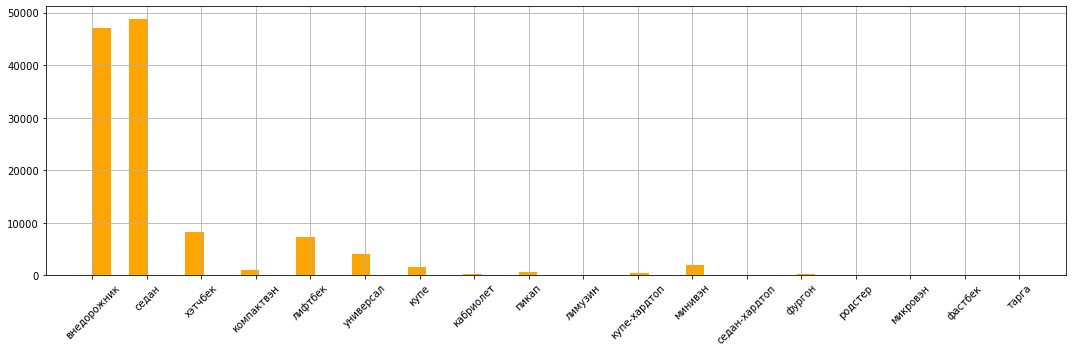

In [13]:
# 1) bodyType - тип автомобиля
print('Пропуски:', data.bodyType.isna().sum())
# слишком много ненужной информации о дверях например
display(data.bodyType.value_counts(dropna=False))
# оставим только первое слово
data.bodyType = data.bodyType.apply(lambda p: p.split()[0]).astype("category")
# display(data.bodyType.value_counts(dropna=False))

data.bodyType.hist(figsize=(15,5), log=False, color='orange', bins=50, xrot=45);
plt.tight_layout()

In [14]:
# Ухудшило метрику. Переименуем редко встречаемые типы автомобилей в other
# other_values = get_other_values(data.bodyType, 50)
# data['body_type_top_n'] = data.bodyType.apply(lambda p: p if p not in other_values else 'other').astype("category")
# data.body_type_top_n.hist(figsize=(15,5), log=False, color='orange', bins=50, xrot=45);
# plt.tight_layout()

# delete_col.append('bodyType')

Пропуски: 0


VOLKSWAGEN    17342
TOYOTA        17014
BMW           15258
NISSAN        14097
MERCEDES      13075
AUDI          11026
MITSUBISHI    10140
SKODA          9140
HONDA          4773
LEXUS          4053
VOLVO          3667
INFINITI       2326
Name: brand, dtype: int64

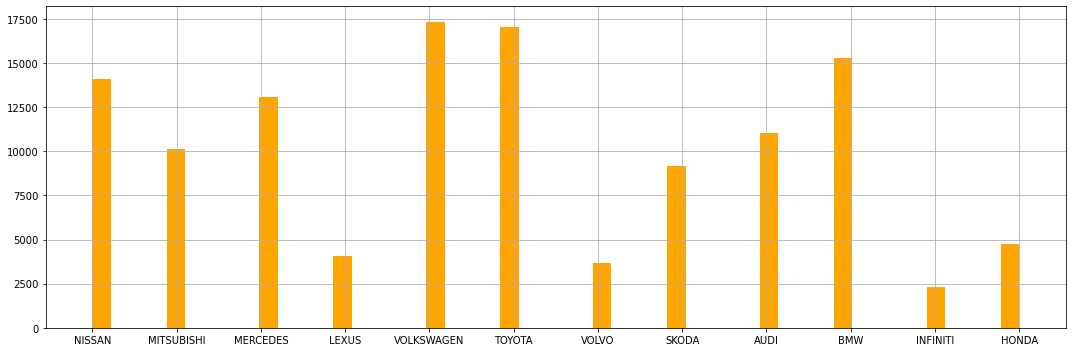

In [15]:
# 2) brand - название бренда
print('Пропуски:', data.brand.isna().sum())
display(data.brand.value_counts(dropna=False))
data.brand = data.brand.astype("category")
# С брендами пока все хорошо, но позже посмотрим может появятся разночтения в названиях

data.brand.hist(figsize=(15,5), log=False, color='orange', bins=50);
plt.tight_layout()

In [16]:
# 3) car_url - url объявления
print('Пропуски:', data.car_url.isna().sum()) # пропусков нет
# уникальные ссылки на объявления
display(data[data.train].car_url.value_counts(dropna=False))
# удалим признак
# data.drop(['car_url'], axis=1, inplace=True)
delete_col.append('car_url')

Пропуски: 0


https://auto.ru/cars/used/sale/toyota/rav_4/1104101220-28c6c4e6/            1
https://auto.ru/cars/used/sale/mercedes/c_klasse/1103061950-db4688dc/       1
https://auto.ru/cars/used/sale/nissan/primera/1099241306-bff23dc2/          1
https://auto.ru/cars/used/sale/audi/q5/1103984156-c6ad8ad6/                 1
https://auto.ru/cars/used/sale/volkswagen/passat_cc/1103961849-7a764ba7/    1
                                                                           ..
https://auto.ru/cars/used/sale/mercedes/s_klasse/1104028558-0c53f237/       1
https://auto.ru/cars/used/sale/toyota/mark_ii/1103925592-57317cb5/          1
https://auto.ru/cars/used/sale/toyota/camry/1104602476-2f1d5e52/            1
https://auto.ru/cars/used/sale/toyota/avensis/1103347237-bc71b165/          1
https://auto.ru/cars/used/sale/mercedes/e_klasse/1104246121-49028e1a/       1
Name: car_url, Length: 87225, dtype: int64

Пропуски: 0


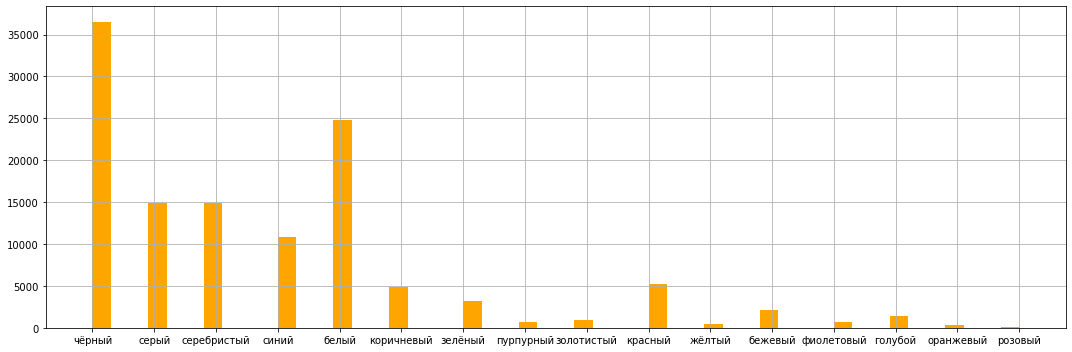

In [17]:
# 4) color - цвет автомобиля
print('Пропуски:', data.color.isna().sum())
# display(data.color.value_counts(dropna=False))
data.color = data.color.astype("category")
# С цветами все хорошо

data.color.hist(figsize=(15,5), log=False, color='orange', bins=50);
plt.tight_layout()

In [18]:
# Ухудшило метрику. Переименуем редко встречаемые цвета автомобилей в other
# other_values = get_other_values(data.color, 85)
# data['color_top_n'] = data.color.apply(lambda p: p if p not in other_values else 'other').astype("category")
# data.color_top_n.hist(figsize=(15,5), log=False, color='orange', bins=50, xrot=45);
# plt.tight_layout()

# delete_col.append('color')

In [19]:
# 5) complectation_dict - словарь комплектации автомобиля
print('Пропуски:', data.complectation_dict.isna().sum()) 
# много пропусков и пустых значений

error_amount =0
def get_json(value):
    if  pd.isnull(value) == False:
        try:
            # декодеру нужны пустые кавычки вместо одинарных 
            s = value.replace("'", "\"").replace("True", '"True"').replace("False", '"False"')                  
#             s = value.replace("'", "\"")
            element_json = json.loads(s)
            return [element_json['name'], element_json['available_options']]
            # print(element_json['name'])
            # print(element_json['available_options'])
        except Exception as err:
            global error_amount
            error_amount += 1
            return [None, None]
#             print(f"Значение: {s}")
#             print(f"Ошибка: {err}")


# display(data.complectation_dict.value_counts(dropna=False)[:10])

# превратим в None пустые комплектации
# data.complectation_dict = data.complectation_dict.apply(lambda p: p if p != "{'id': '0'}" else  None)
# display(data.complectation_dict.value_counts(dropna=False)[:10])

# data[['complectation_name', 'complectation_available_options']] = data.complectation_dict.map(get_json)


# data['complectation_name'], data['complectation_available_options'] =  data.complectation_dict.map(get_json)
# for s,y in zip(data.complectation_dict.map(get_json)):
#     print(s)
# data[['complectation_name', 'complectation_available_options']] = data.complectation_dict.map(get_json).apply(pd.Series)
# display(data.complectation_dict.value_counts(dropna=False)[:10])
# print(f"Количество ошибок: {error_amount}")

Пропуски: 28271


In [20]:
data[~data.train].info()

# Слишком много пропусков в комплектации скорее всего нужно удалить
delete_col.append('complectation_dict')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 87225 to 121910
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bodyType              34686 non-null  category
 1   brand                 34686 non-null  category
 2   car_url               34686 non-null  object  
 3   color                 34686 non-null  category
 4   complectation_dict    6418 non-null   object  
 5   description           34686 non-null  object  
 6   engineDisplacement    34686 non-null  object  
 7   enginePower           34686 non-null  object  
 8   equipment_dict        24690 non-null  object  
 9   fuelType              34686 non-null  object  
 10  image                 34686 non-null  object  
 11  mileage               34686 non-null  int64   
 12  modelDate             34686 non-null  float64 
 13  model_info            34686 non-null  object  
 14  model_name            34686 non-null  object  
 1

In [21]:
# 6) description - текстовое описание продавца
# display(data.description.value_counts(dropna=False)[:2])

# Описание технического состояния ТС, выполненное продавцом. Без применения анализа текстов признак не применим.

# Источником косвенной информации о типе продавца является аннотация к объявлению о продаже, сосредоточенная в признаке description. 
# Исползуем проверку по ключевым словам для установления типа продавца.
data.description = data.description.str.lower()

data['is_owner'] = data.description.apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
data['is_showroom'] = data.description.apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                             or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                             or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(data.is_owner.value_counts())
display(data.is_showroom.value_counts())

# Удаляем признак
delete_col.append('description')

0    60989
1    60922
Name: is_owner, dtype: int64

0    82753
1    39158
Name: is_showroom, dtype: int64

In [22]:
def discount(x):
    if 'скидк' in x or 'торг' in x or 'подар' in x or 'выгодное пр' in x:
        return 1
    else:
        return 0
    
def credit(x):
    if 'trade-in' in x or 'трейд' in x or 'кредит' in x:
        return 1
    else:
        return 0
# Добавим колонку скидок    
data['is_discount'] = data.description.apply(discount)
# Добавим колонку с предложением traid-id и кредита
data['is_credit'] = data.description.apply(credit)

display(data.is_discount.value_counts())
display(data.is_credit.value_counts())

0    77952
1    43959
Name: is_discount, dtype: int64

0    93245
1    28666
Name: is_credit, dtype: int64

In [23]:
# 7) engineDisplacement - объем двигателя
print('Пропуски:', data.engineDisplacement.isna().sum())
# но если преобразовать в число то нужно убрать слово LTR 
display(data.engineDisplacement.value_counts(dropna=False))

data.engineDisplacement = data.engineDisplacement.apply(lambda p: p.rpartition(' LTR')[0])
data.engineDisplacement = data.engineDisplacement.apply(lambda p: p if p != '' else None).astype("float")

display(data.engineDisplacement.value_counts(dropna=False))

Пропуски: 0


2.0 LTR    27218
1.6 LTR    19046
3.0 LTR    13278
1.8 LTR    11662
2.5 LTR     8214
1.4 LTR     6298
2.4 LTR     5487
3.5 LTR     5460
1.5 LTR     3250
1.2 LTR     1772
4.5 LTR     1638
2.8 LTR     1394
1.3 LTR     1377
4.7 LTR     1255
3.2 LTR     1246
4.4 LTR     1118
4.0 LTR      995
2.2 LTR      919
1.9 LTR      862
4.2 LTR      754
2.3 LTR      731
3.6 LTR      726
2.7 LTR      704
5.5 LTR      703
3.7 LTR      629
2.1 LTR      532
5.7 LTR      515
4.6 LTR      509
5.0 LTR      452
2.9 LTR      429
5.6 LTR      423
1.0 LTR      302
4.8 LTR      271
2.6 LTR      248
3.1 LTR      224
1.7 LTR      180
3.3 LTR      162
3.8 LTR      141
3.4 LTR      136
4.3 LTR      125
6.0 LTR      116
4.1 LTR      104
 LTR          63
0.7 LTR       53
5.4 LTR       38
6.2 LTR       29
5.9 LTR       27
6.6 LTR       20
5.8 LTR       18
4.9 LTR       14
6.3 LTR       13
5.2 LTR       12
1.1 LTR       10
3.9 LTR        8
5.3 LTR        1
Name: engineDisplacement, dtype: int64

2.0    27218
1.6    19046
3.0    13278
1.8    11662
2.5     8214
1.4     6298
2.4     5487
3.5     5460
1.5     3250
1.2     1772
4.5     1638
2.8     1394
1.3     1377
4.7     1255
3.2     1246
4.4     1118
4.0      995
2.2      919
1.9      862
4.2      754
2.3      731
3.6      726
2.7      704
5.5      703
3.7      629
2.1      532
5.7      515
4.6      509
5.0      452
2.9      429
5.6      423
1.0      302
4.8      271
2.6      248
3.1      224
1.7      180
3.3      162
3.8      141
3.4      136
4.3      125
6.0      116
4.1      104
NaN       63
0.7       53
5.4       38
6.2       29
5.9       27
6.6       20
5.8       18
4.9       14
6.3       13
5.2       12
1.1       10
3.9        8
5.3        1
Name: engineDisplacement, dtype: int64

2.0    41193
1.5    30151
3.0    16571
2.5    15447
3.5     7113
4.5     4645
1.0     2084
4.0     2002
5.5     1680
5.0      749
6.0      190
0.5       53
6.5       33
Name: engineDisplacement, dtype: int64

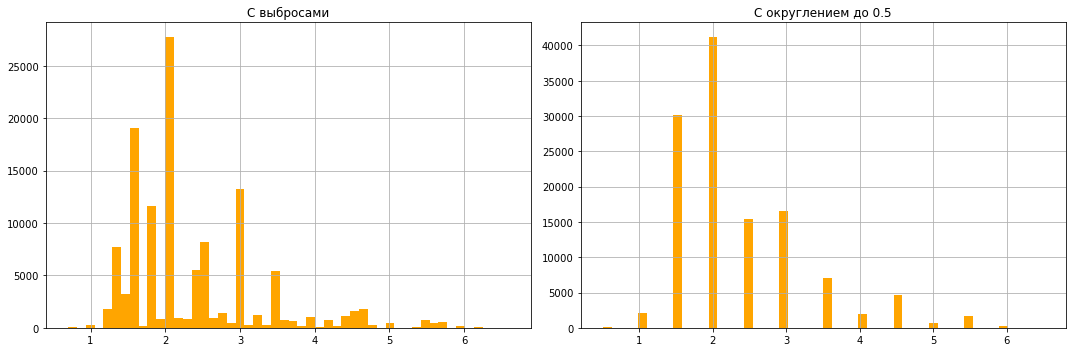

In [24]:
# заполним пропуски средним
data.engineDisplacement.fillna(round(data[data.train].engineDisplacement.mean(),1), inplace=True)
# display(data.engineDisplacement.value_counts(dropna=False))


fig ,ax = plt.subplots(1,2,figsize=(10, 20));
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.engineDisplacement.hist(figsize=(15,5), log=False, color='orange', bins=50, ax=ax1);

# округлим разброс объема двигателя до 0.5
data.engineDisplacement = data.engineDisplacement.apply(lambda p: myround(p, 1, .5))
display(data.engineDisplacement.value_counts(dropna=False))
# # Удалять выбросы не будем, тк можно удалить данные из тестового датасета, поэтому заменим выбросы крайними значениями. 
# perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.enginePower)

# data.enginePower.loc[data.enginePower < min_emission_limits] = int(perc1)
# data.enginePower.loc[data.enginePower > max_emission_limits] = int(perc99)

ax2.set_title('С округлением до 0.5')
data.engineDisplacement.hist(figsize=(15,5), log=False, color='orange', bins=50, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

Пропуски: 0


150 N12    7155
249 N12    6850
110 N12    4400
105 N12    3674
184 N12    3439
           ... 
198 N12       1
522 N12       1
164 N12       1
480 N12       1
630 N12       1
Name: enginePower, Length: 330, dtype: int64

0

150    12669
100    10946
180    10277
140     9826
120     8379
       ...  
490        2
30         2
550        2
590        1
640        1
Name: enginePower, Length: 62, dtype: int64

| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|70.0|-30.0|120.0|100.0|220.0|370.0|440.0|

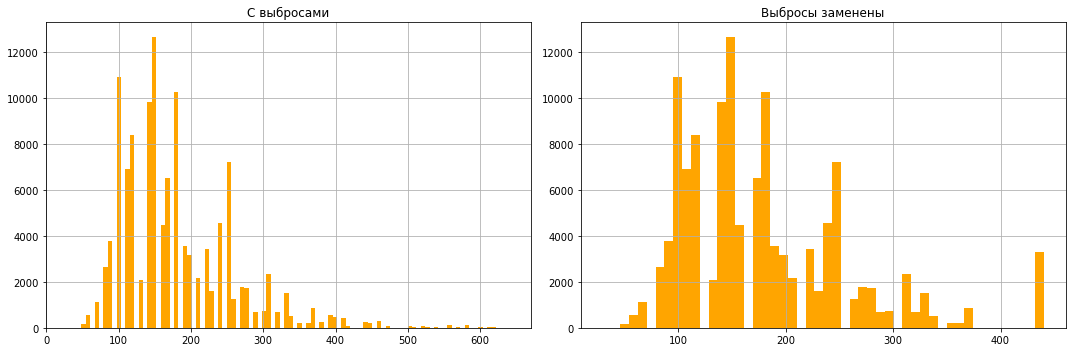

In [25]:
# 8) enginePower - мощность двигателя
print('Пропуски:', data.enginePower.isna().sum())
display(data.enginePower.value_counts(dropna=False))
# если преобразовать в число то есть слово LTR


data.enginePower = data.enginePower.apply(lambda p: p.rpartition(' N12')[0])
data.enginePower = data.enginePower.apply(lambda p: p if p != '' else None).astype("float")

# округлим мощность до 10 лошадиных сил
data.enginePower = data.enginePower.apply(lambda p: round(p, -1)).astype("int")

display(data.enginePower.isna().sum()) # пропусков нет
display(data.enginePower.value_counts(dropna=False))

# по графику видно что есть выбросы
# data.enginePower.hist(figsize=(15,5), log=False, color='orange', bins=100);
fig ,ax = plt.subplots(1,2,figsize=(10, 20))
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.enginePower.hist(figsize=(15,5), log=False, color='orange', bins=100, ax=ax1);

# Удалять выбросы не будем, тк можно удалить данные из тестового датасета, поэтому заменим выбросы крайними значениями. 
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.enginePower)

data.loc[data.enginePower < min_emission_limits, 'enginePower'] = int(perc1)
data.loc[data.enginePower > max_emission_limits, 'enginePower'] = int(perc99)
# data.enginePower.loc[data.enginePower < min_emission_limits] = int(perc1)
# data.enginePower.loc[data.enginePower > max_emission_limits] = int(perc99)

ax2.set_title('Выбросы заменены')
data.enginePower.hist(figsize=(15,5), log=False, color='orange', bins=50, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

In [26]:
# 9) equipment_dict - словарь оборудования автомобиля
print('Пропуски:', data.equipment_dict.isna().sum()) 
# много пропусков и пустых значений

############## Посмотрю позже сейчас сложно выделять признаки из комплектации

error_amount =0
def get_json(value):
    if  pd.isnull(value) == False:
        try:
            # декодеру нужны пустые кавычки вместо одинарных 
            s = value.replace("'", "\"").replace("True", '"True"').replace("False", '"False"')                  
#             s = value.replace("'", "\"")
            element_json = json.loads(s)
            return [element_json['name'], element_json['available_options']]
            # print(element_json['name'])
            # print(element_json['available_options'])
        except Exception as err:
            global error_amount
            error_amount += 1
            return [None, None]
#             print(f"Значение: {s}")
#             print(f"Ошибка: {err}")


s = data.equipment_dict.value_counts(dropna=False)

display(s[s > 10][:10])

# display(data.equipment_dict.value_counts(dropna=False)[:10])

# превратим в None пустые комплектации
# data.complectation_dict = data.complectation_dict.apply(lambda p: p if p != "{'id': '0'}" else  None)
# display(data.complectation_dict.value_counts(dropna=False)[:10])

# data[['complectation_name', 'complectation_available_options']] = data.complectation_dict.map(get_json)


# data['complectation_name'], data['complectation_available_options'] =  data.complectation_dict.map(get_json)
# for s,y in zip(data.complectation_dict.map(get_json)):
#     print(s)
# data[['complectation_name', 'complectation_available_options']] = data.complectation_dict.map(get_json).apply(pd.Series)



# display(data.complectation_dict.value_counts(dropna=False)[:10])
# print(f"Количество ошибок: {error_amount}")

delete_col.append('equipment_dict')

Пропуски: 9996


{}                             28272
NaN                             9996
{'alarm': True}                  567
{'gbo': True}                    358
{'leather': True}                324
{'condition': True}              283
{'alloy-wheel-disks': True}      236
{'hatch': True}                  179
{'audiosystem-cd': True}         139
{'climate-control-1': True}      125
Name: equipment_dict, dtype: int64

Пропуски: 0


бензин     100005
дизель      20613
гибрид       1199
электро        63
газ            31
Name: fuelType, dtype: int64

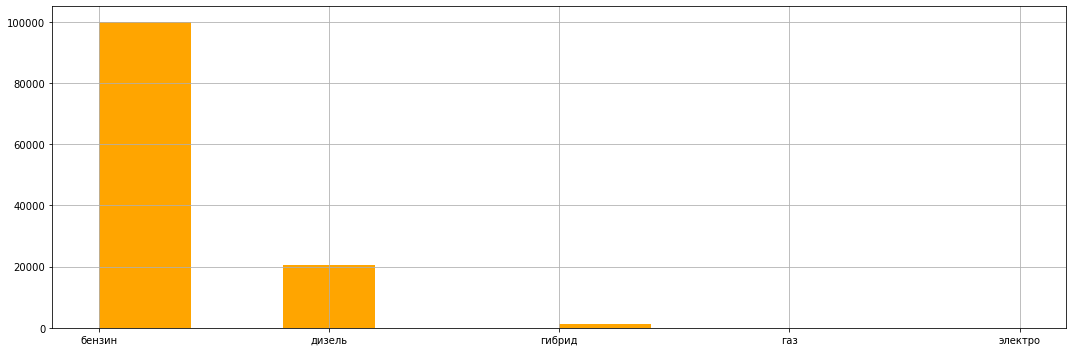

In [27]:
# 10) fuelType - тип топлива
print('Пропуски:', data.fuelType.isna().sum())
display(data.fuelType.value_counts(dropna=False))
data.fuelType = data.fuelType.astype("category")

data.fuelType.hist(figsize=(15,5), log=False, color='orange');
plt.tight_layout()

In [28]:
#11) image - url изображения автомобиля
# Пока удалю тк признак не несет никакой информации, хотя признак отсутсвия изображения могбы быть хорошим признаком.
# train всегда содержит изображение
display(data[~data.train].image.isna().sum())
delete_col.append('image')

0

Пропуски: 0


200000    1837
300000    1696
250000    1493
150000    1326
180000    1234
          ... 
59380        1
192501       1
63478        1
165880       1
6147         1
Name: mileage, Length: 31397, dtype: int64

| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|4000.0|-102500.0|94000.0|131000.0|225000.0|421500.0|470000.0|

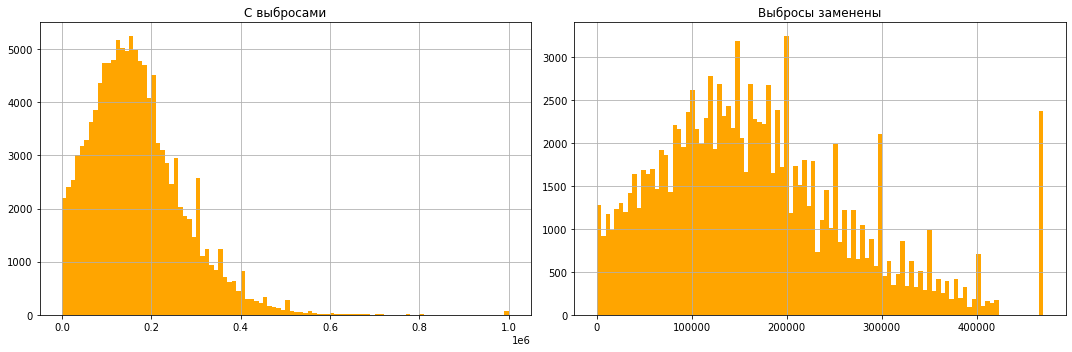

In [29]:
# 12) mileage - пробег
print('Пропуски:', data.mileage.isna().sum())
display(data.mileage.value_counts(dropna=False))

# округлим пробег до 1000 км
data.mileage = data.mileage.apply(lambda p: round(p, -3)).astype("int")
# display(data.mileage_round.value_counts(dropna=False))

# по графику видно что есть выбросы
fig ,ax = plt.subplots(1,2,figsize=(10, 20))
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.mileage.hist(figsize=(15,5), log=False, color='orange', bins=100, ax=ax1);

# Удалять выбросы не будем, тк можно удалить данные из тестового датасета, поэтому заменим выбросы крайними значениями. 
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.mileage)

# data.mileage.loc[data.mileage < min_emission_limits] = int(perc1)
# data.mileage.loc[data.mileage > max_emission_limits] = int(perc99)

data.loc[data.mileage < min_emission_limits, 'mileage'] = int(perc1)
data.loc[data.mileage > max_emission_limits, 'mileage'] = int(perc99)

ax2.set_title('Выбросы заменены')
data.mileage.hist(figsize=(15,5), log=False, color='orange', bins=100, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

In [30]:

# fig ,ax = plt.subplots(1,2,figsize=(35, 10))
# ax1,ax2 = ax.flatten()
# sns.countplot(data=data, x='mileage', hue=None, palette='gist_rainbow', ax=ax1);
# # sns.countplot(data=data, x='mileage', hue=None, palette='viridis', ax=ax2);

# sns.factorplot(data.mileage, aspect=2,
#                        kind="count", color='steelblue', ax=ax2)
# # sns.barplot(x=data.mileage.value_counts(), ax=ax2)
    
# # plt.tight_layout()

Пропуски: 0
Максимальный год выпуска: 2020.0


| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|1984.0|1990.5|2004.0|9.0|2013.0|2026.5|2019.0|

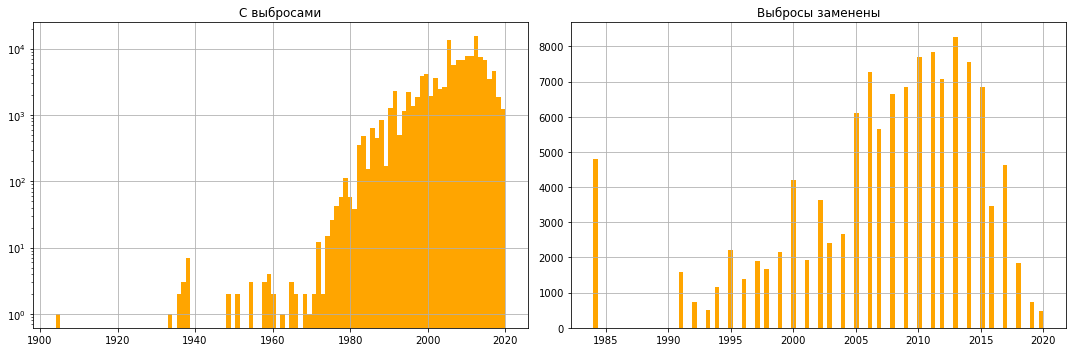

In [31]:
# 13) modelDate - год выпуска модели
print('Пропуски:', data.modelDate.isna().sum())
# display(data.modelDate.value_counts(dropna=False))

# Есть выбросы - ошибка или раритет с огромной ценой нужно подумать удалять или заменять на минимум
# Нужно принять решение толь для нижней границы, с верхней все нормально
print('Максимальный год выпуска:', data.modelDate.max())

# по графику видно что есть выбросы
fig ,ax = plt.subplots(1,2,figsize=(10, 20))
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.modelDate.hist(figsize=(15,5), log=True, color='orange', bins=100, ax=ax1);

perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.modelDate)

# заменим только нижнюю границу
data.loc[data.modelDate < min_emission_limits, 'modelDate'] = int(perc1) 
# data.modelDate.loc[data.modelDate < min_emission_limits] = int(perc1) 
data.modelDate = data.modelDate.astype('int')


ax2.set_title('Выбросы заменены')
data.modelDate.hist(figsize=(15,5), log=False, color='orange', bins=100, ax=ax2);
plt.tight_layout()

In [32]:
# 14) model_info - словарь информации об автомобиле
print('Пропуски:', data.model_info.isna().sum())
display(data.model_info.value_counts(dropna=False))

# удаляем признак
delete_col.append('model_info')

# посмотрим позже

Пропуски: 0


{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_name': 'Октавия', 'morphology': {'gender': 'FEMININE'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                    2918
{'code': 'POLO', 'name': 'Polo', 'ru_name': 'Поло', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                                                 2897
{'code': 'CAMRY', 'name': 'Camry', 'ru_name': 'Камри', 'morphology': {'gender': 'FEMININE'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                          2837
{'code': 'PASSAT', 'name': 'Passat', 'ru_name': 'Пассат', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                                           2773
{'code': 'COROLLA', 'name': 'Corolla', 'ru_name': 'Королла', 'morphology': {'gender': 'FEMININE'}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}                    2202
                                                                                          

In [33]:
# 15) model_name - тип модели
print('Пропуски:', data.model_name.isna().sum())
display(data.model_name.value_counts(dropna=False).sort_index())

# В названиях модели некоторые марки отличаются написание символами (- и _ и пробел). 
# Заменим эти символы в начале программы, где считаем спрос.

data.model_name = data.model_name.astype("category")

# data.model_name.hist(figsize=(30,5), log=False, color='orange', bins=100, xrot=90);

# pd.crosstab( data.model_name,  data.brand).plot.bar(figsize=(15,5), xlabel='car_status / default', ylabel='Frequency of Purchase', title='Frequency of Purchase for car_status / default', rot=0);
# pd.crosstab(data.brand, data.model_name  ).plot.bar(figsize=(15,5), xlabel='car_status / default', ylabel='Frequency of Purchase', title='Frequency of Purchase for car_status / default', rot=0);
# data.color = data.color.astype("category")

# data[['brand', 'model_name']].value_counts().reset_index()

# !!!!!! Марок очень много подумаю позже


# scatter_for_two_columns_with_count(data, 'brand',  'model_name')
# data.model_name

Пропуски: 0


02             1
100          693
100NX          1
100SERIES      1
120            2
            ... 
Z1             1
Z3             4
Z3M            1
Z4            19
ZEST           2
Name: model_name, Length: 563, dtype: int64

In [34]:
# 16) name - харакетиристика конкретной модели
print('Пропуски:', data.name.isna().sum())
data.name = data.name.str.upper()
display(data.name.value_counts(dropna=False))

# Признак содержит общую информацию которую можно есть в других признаках.
# удаляем признак
delete_col.append('name')

Пропуски: 0


VOLKSWAGEN POLO V РЕСТАЙЛИНГ        1507
VOLKSWAGEN POLO V                   1089
VOLKSWAGEN TIGUAN I РЕСТАЙЛИНГ      1080
SKODA OCTAVIA II (A5) РЕСТАЙЛИНГ     815
SKODA OCTAVIA III (A7)               813
                                    ... 
G25 2.5 AT (222 Л.С.) 4WD              1
2.5D MT (109 Л.С.)                     1
200 2.0D AT (75 Л.С.)                  1
118I 2.0 MT (136 Л.С.)                 1
FIELDER 1.5 CVT (105 Л.С.) 4WD         1
Name: name, Length: 4483, dtype: int64

In [35]:
# 17) numberOfDoors - количество дверей
print('Пропуски:', data.numberOfDoors.isna().sum())
data.numberOfDoors = data.numberOfDoors.astype("int")
display(data.numberOfDoors.value_counts(dropna=False))

# В тестовом датасете есть интересный авто у которого 0 дверей - MERCEDES SIMPLEX.
data[data.numberOfDoors == 0]

Пропуски: 0


5    66789
4    50808
2     2510
3     1803
0        1
Name: numberOfDoors, dtype: int64

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit
104169,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.кат...",5.5,30,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,48000,1984,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",SIMPLEX,5.3 MT (32 Л.С.),0,1.603246e+09,RUB,1904.0,1093802104,"{""id"":""21743990"",""displacement"":5322,""engine_t...",CABRIO MECHANICAL 5.3,механическая,EUROPEAN,1 владелец,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,-1.0,False,0,0,0,0


In [36]:
# 18) parsing_unixtime - дата парсинга данных
print('Пропуски:', data.parsing_unixtime.isna().sum())
# data.numberOfDoors = data.numberOfDoors.astype("int")


# data.parsing_unixtime = data.parsing_unixtime.apply(lambda p: datetime.datetime.fromtimestamp(p).date())
# display(data[['parsing_unixtime', 'train']].value_counts())

# Видно что тренировочная и тестовая выгрузки сделаны в разное время.
# Приходит на ум ввести поправочный коэффициент цен относительно курса доллара
dollar_rate_2021_07 = 0.014 #(1 рубль = 0,014 доллара)
dollar_rate_2020_10 = 0.013

# Вводим поправочный коэффициент на цены тестового датасета
# data[data.train].price = data[data.train].price.apply(lambda price: (price * dollar_rate_2021_07) * (1 / dollar_rate_2020_10)).astype("int")

display(data[data.train].price[:10])
# 0.90 - 0.96
data.loc[data.train, ['price']] = data.loc[data.train, ['price']] * 0.895
display(data[data.train].price[:10])

# удаляем признак
delete_col.append('parsing_unixtime')

Пропуски: 0


0    1128000.0
1    1199000.0
2    1078000.0
3     895000.0
4     868000.0
5    1230000.0
6    1050000.0
7    1067000.0
8    1330000.0
9     895000.0
Name: price, dtype: float64

0    1009560.0
1    1073105.0
2     964810.0
3     801025.0
4     776860.0
5    1100850.0
6     939750.0
7     954965.0
8    1190350.0
9     801025.0
Name: price, dtype: float64

In [37]:
# 19) priceCurrency - тип валюты
print('Пропуски:', data.priceCurrency.isna().sum())
display(data.priceCurrency.value_counts(dropna=False))

# В этом признаке встречается только одно значение
# удаляем признак
delete_col.append('priceCurrency')

Пропуски: 0


RUB    121911
Name: priceCurrency, dtype: int64

Пропуски: 0
Максимальный год выпуска: 2021.0


| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|1988.0|1992.5|2006.0|9.0|2015.0|2028.5|2020.0|

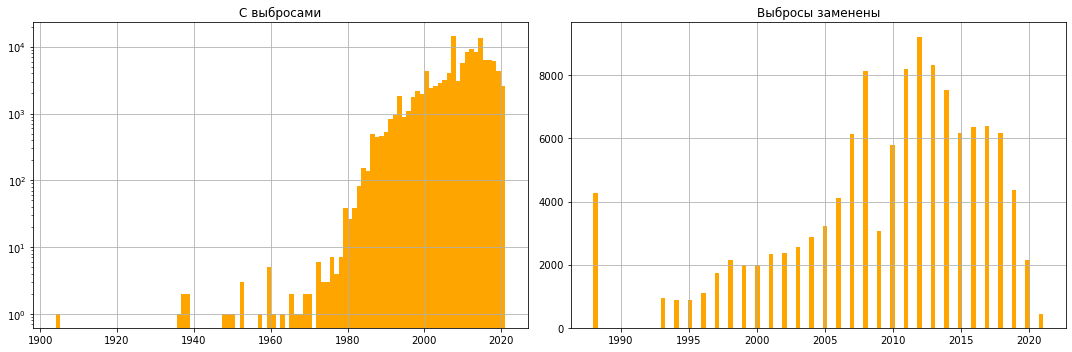

In [38]:
# 20) productionDate - год производства автомобиля
print('Пропуски:', data.productionDate.isna().sum())
# display(data.productionDate.value_counts(dropna=False))

# Есть выбросы - ошибка или раритет с огромной ценой нужно подумать удалять или заменять на минимум
# Нужно принять решение толь для нижней границы, с верхней все нормально
print('Максимальный год выпуска:', data.productionDate.max())

# по графику видно что есть выбросы
fig ,ax = plt.subplots(1,2,figsize=(10, 20))
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.productionDate.hist(figsize=(15,5), log=True, color='orange', bins=100, ax=ax1);

perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.productionDate)

# заменим только нижнюю границу
data.loc[data.productionDate < min_emission_limits, 'productionDate'] = int(perc1) 
# data.productionDate.loc[data.productionDate < min_emission_limits] = int(perc1) 
data.productionDate = data.productionDate.astype('int')

ax2.set_title('Выбросы заменены')
data.productionDate.hist(figsize=(15,5), log=False, color='orange', bins=100, ax=ax2);
plt.tight_layout()

In [39]:
# Проверим чтобы дата производства авто не была меньше даты выпуска модели
difference = (data.productionDate - data.modelDate).value_counts(dropna=False)
display(difference[difference.index < 0])

# Есть несостыковки, присвоим таким значениям дату производства модели
data.productionDate = data.apply(lambda p: p.modelDate if (p.productionDate - p.modelDate < 0) else p.productionDate, axis=1)

difference = (data.productionDate - data.modelDate).value_counts(dropna=False)
display(difference[difference.index < 0])

data['data_difference'] = (data.productionDate - data.modelDate)

-3    445
-4     86
-1     19
-2      3
dtype: int64

Series([], dtype: int64)

In [40]:
# 21) sell_id - номер объявления
print('Пропуски:', data.sell_id.isna().sum())
display(data.sell_id[data.train].value_counts(dropna=False))

# В этом признаке встречается только уникальные значения
# удаляем признак
delete_col.append('sell_id')

Пропуски: 0


1096421374    1
1103667905    1
1102643893    1
1104222902    1
1104112312    1
             ..
1101209891    1
1103865246    1
1104260511    1
1103494407    1
1094975488    1
Name: sell_id, Length: 87225, dtype: int64

In [41]:
# 22) super_gen - словарь характеристик текущего поколения автомобиля
print('Пропуски:', data.super_gen.isna().sum())
display(data.super_gen.value_counts(dropna=False))


# удаляем признак
delete_col.append('super_gen')

Пропуски: 0


{'id': '20113124', 'name': 'V Рестайлинг', 'ru_name': '5 Рестайлинг', 'year_from': 2014, 'year_to': 2020, 'price_segment': 'ECONOMY'}                                                                                                                                                  1507
{'id': '5019213', 'name': 'V', 'ru_name': '5', 'year_from': 2009, 'year_to': 2015, 'price_segment': 'ECONOMY'}                                                                                                                                                                         1090
{'id': '7339785', 'name': 'I Рестайлинг', 'ru_name': '1 Рестайлинг', 'year_from': 2011, 'year_to': 2016, 'price_segment': 'MEDIUM'}                                                                                                                                                    1084
{'id': '4560887', 'name': 'II (A5) Рестайлинг', 'ru_name': '2 Рестайлинг', 'year_from': 2008, 'year_to': 2013, 'price_segment': 'MEDIUM'}           

In [42]:
# 23) vehicleConfiguration - конфигурация автомобиля
print('Пропуски:', data.vehicleConfiguration.isna().sum())
display(data.vehicleConfiguration.value_counts(dropna=False))
# display(data[['bodyType', 'vehicleConfiguration']].value_counts())
# Информация содержащаяся в этом признаке встречается в других признаках
# удаляем признак
delete_col.append('vehicleConfiguration')

Пропуски: 0


ALLROAD_5_DOORS AUTOMATIC 3.0    9104
SEDAN AUTOMATIC 2.0              6074
SEDAN MECHANICAL 1.6             6035
ALLROAD_5_DOORS AUTOMATIC 2.0    5756
ALLROAD_5_DOORS VARIATOR 2.0     5518
                                 ... 
ALLROAD_OPEN AUTOMATIC 2.0          1
CABRIO ROBOT 3.3                    1
MICROVAN MECHANICAL 0.7             1
SEDAN MECHANICAL 4.2                1
COUPE ROBOT 3.3                     1
Name: vehicleConfiguration, Length: 716, dtype: int64

In [43]:
# 24) vehicleTransmission - тип трансмиссии
print('Пропуски:', data.vehicleTransmission.isna().sum())
display(data.vehicleTransmission.value_counts(dropna=False))
data.vehicleTransmission = data.vehicleTransmission.astype("category")

Пропуски: 0


автоматическая      66695
механическая        28574
вариатор            15065
роботизированная    11577
Name: vehicleTransmission, dtype: int64

In [44]:
# 25) vendor - регион производства автомобиля
print('Пропуски:', data.vendor.isna().sum())
display(data.vendor.value_counts(dropna=False))

display(data[data.vendor.isna()])
# Тк пропуски встречаются только в трайне - удалим их
data = data[~data.vendor.isna()]
data.vendor = data.vendor.astype("category")

Пропуски: 5


EUROPEAN    69504
JAPANESE    52402
NaN             5
Name: vendor, dtype: int64

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference
3453,внедорожник,NISSAN,https://auto.ru/cars/used/sale/nissan/x_trail/...,оранжевый,"{'id': '21436767', 'name': 'LE Yandex (2018-20...",1 владелец!!!\nавтомобиль с полным ндс!!! возм...,2.5,170,"{'mirrors-heat': True, 'seats-5': True, 'usb':...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,18000,2017,"{'code': 'X_TRAIL', 'name': 'X-Trail', 'ru_nam...",XTRAIL,NISSAN X-TRAIL III РЕСТАЙЛИНГ,5,1.626686e+09,RUB,2018,1103847423,"{'id': '21179303', 'name': 'III Рестайлинг', '...",ALLROAD_5_DOORS VARIATOR 2.5,вариатор,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1852650.0,True,0,1,1,1,1
49085,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,серебристый,"{'id': '21032077', 'name': 'Active', 'availabl...",автомобиль продается от дилерского центра ррт ...,1.5,90,"{'heated-wash-system': True, 'computer': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,34000,2017,"{'code': 'RAPID', 'name': 'Rapid', 'ru_name': ...",RAPID,SKODA RAPID I РЕСТАЙЛИНГ,5,1.626696e+09,RUB,2020,1104232698,"{'id': '21005574', 'name': 'I Рестайлинг', 'ru...",LIFTBACK MECHANICAL 1.6,механическая,NaN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,885155.0,True,0,1,1,1,3
52537,внедорожник,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1104...,коричневый,NaN,автомобиль продается от дилерского центра ррт ...,1.0,100,"{'computer': True, 'wheel-configuration1': Tru...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,122000,2013,"{'code': 'YETI', 'name': 'Yeti', 'ru_name': 'Й...",YETI,SKODA YETI I РЕСТАЙЛИНГ,5,1.626697e+09,RUB,2014,1104189605,"{'id': '20078038', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS MECHANICAL 1.2,механическая,NaN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,670355.0,True,0,1,1,1,1
64308,купе,AUDI,https://auto.ru/cars/used/sale/audi/a5/1104201...,серый,NaN,"ауди центр север — официальный дилер audi, вхо...",2.0,230,"{'light-cleaner': True, 'climate-control-1': T...",бензин,https://autoru.naydex.net/AIOo9k096/4706b0sQt7...,25000,2011,"{'code': 'A5', 'name': 'A5', 'ru_name': 'А5'}",A5,AUDI A5 I (8T) РЕСТАЙЛИНГ,2,1.626601e+09,RUB,2016,1104201302,"{'id': '7721546', 'name': 'I (8T) Рестайлинг',...",COUPE ROBOT 2.0,роботизированная,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2102355.0,True,0,1,0,1,5
64337,купе,AUDI,https://auto.ru/cars/used/sale/audi/a5/1103720...,серый,NaN,"ауди центр север — официальный дилер audi, вхо...",2.0,250,"{'light-cleaner': True, 'abs': True, 'rear-cam...",бензин,https://autoru.naydex.net/AIOo9k096/4706b0sQt7...,71000,2016,"{'code': 'A5', 'name': 'A5', 'ru_name': 'А5'}",A5,AUDI A5 II (F5),2,1.626601e+09,RUB,2017,1103720126,"{'id': '20795592', 'name': 'II (F5)', 'ru_name...",COUPE ROBOT 2.0,роботизированная,NaN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2236605.0,True,0,1,0,1,1


In [45]:
# 26) Владельцы - количество владельцев
print('Пропуски:', data.Владельцы.isna().sum())
display(data.Владельцы.value_counts(dropna=False).to_dict())

display(data[data.Владельцы.isna()])
# Тк пропуски встречаются только в трайне - удалим их
data = data[~data.Владельцы.isna()]

data.Владельцы = data.Владельцы.apply(lambda p: p.replace(u'\xa0', u' ') )
display(data.Владельцы.value_counts(dropna=False).to_dict())

# owners_dic = {'1 владелец': 1, '2 владельца': 2, '3 или более': 3 }
# data.Владельцыа = data.Владельцы.map(owners_dic)
# display(data.Владельцыа.value_counts(dropna=False))

# Преобразуем признак в категориальный с определенным порядком категорий
data.Владельцы = pd.Categorical(data.Владельцы, categories=['1 владелец', '2 владельца', '3 или более'], ordered=False)



#data['DDD'] = data['SSS'].cat.codes

# LabelEncoder()
# le = LabelEncoder()
# data['YYY'] = le.fit_transform(data['SSS'])
# data.sample(20)
# # display(data[['Владельцы', 'Владельцыа', 'Владельцыб', 'Владельцыв']].value_counts())

Пропуски: 6


{'3 или более': 60674, '1\xa0владелец': 31378, '2\xa0владельца': 29848, nan: 6}

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference
6546,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera/1...,чёрный,{'id': '0'},"nissan almera classic чёрный седан, 2005 г., п...",1.5,100,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,97000,2002,"{'code': 'ALMERA', 'name': 'Almera', 'ru_name'...",ALMERA,NISSAN ALMERA II (N16) РЕСТАЙЛИНГ,4,1.626678e+09,RUB,2005,1018963419,"{'id': '4602011', 'name': 'II (N16) Рестайлинг...",SEDAN MECHANICAL 1.5,механическая,JAPANESE,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,268500.0,True,1,0,1,0,3
29679,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,серебристый,{'id': '0'},полный привод,2.5,150,"{'electro-window-back': True, 'asr': True, 'es...",дизель,https://autoru.naydex.net/eSFc9Z271/5f5d81kUZA...,290000,2000,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",PASSAT,VOLKSWAGEN PASSAT B5 РЕСТАЙЛИНГ,4,1.626709e+09,RUB,2001,1075710691,"{'id': '4760841', 'name': 'B5 Рестайлинг', 'ru...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,241650.0,True,1,0,0,0,1
40846,минивэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/cara...,синий,{'id': '0'},обмен на предложенное.при осмотре хороший торг!,2.5,120,"{'alloy-wheel-disks': True, 'tinted-glass': Tr...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,265000,1991,"{'code': 'CARAVELLE', 'name': 'Caravelle', 'ru...",CARAVELLE,VOLKSWAGEN CARAVELLE T4,4,1.626706e+09,RUB,1997,1051816170,"{'id': '6016469', 'name': 'T4', 'year_from': 1...",MINIVAN MECHANICAL 2.5,механическая,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,492250.0,True,1,0,1,0,6
48226,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серый,{'id': '0'},авто в хорошем состоянии. не битый. не крашены...,1.5,100,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,140000,2000,"{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...",OCTAVIA,SKODA OCTAVIA I (A4) РЕСТАЙЛИНГ,5,1.626696e+09,RUB,2007,1018345457,"{'id': '2309186', 'name': 'I (A4) Рестайлинг',...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,NaN,7 лет и 11 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен,331150.0,True,0,0,0,0,7
70917,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/103809...,синий,{'id': '0'},продам ауди кватро в хорошем состоянии остальн...,3.0,170,{},бензин,https://autoru.naydex.net/AIOo9k096/4706b0sQt7...,365000,1984,"{'code': '100', 'name': '100', 'ru_name': '100...",100,AUDI 100 IV (C4),4,1.626600e+09,RUB,1988,1038096426,"{'id': '7879464', 'name': 'IV (C4)', 'ru_name'...",SEDAN MECHANICAL 2.8,механическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,152150.0,True,1,0,1,0,4
71710,седан,AUDI,https://auto.ru/cars/used/sale/audi/100/103651...,белый,{'id': '0'},год выпуска: 1985. пробег: 155 000 км. кузов: ...,2.0,120,{},бензин,https://autoru.naydex.net/AIOo9k096/4706b0sQt7...,155000,1984,"{'code': '100', 'name': '100', 'ru_name': '100...",100,AUDI 100 III (C3),4,1.626600e+09,RUB,1988,1036512348,"{'id': '7892647', 'name': 'III (C3)', 'ru_name...",SEDAN MECHANICAL 2.0,механическая,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,71600.0,True,0,0,0,0,4


{'3 или более': 60674, '1 владелец': 31378, '2 владельца': 29848}

In [46]:
# 27) Владение - срок владения продавцом автомобиля
print('Пропуски:', data.Владение.isna().sum())
display(data.Владение.value_counts(dropna=False))

# Признак очень интересный но он имет пропуски у 60% строк - пока удалим
# удаляем признак
# delete_col.append('Владение')

#!!! Возможно можно сделать признак ['нет', 'мало', 'долго'], 

Пропуски: 84471


NaN                   84471
9 месяцев               696
11 месяцев              692
10 месяцев              629
8 месяцев               621
                      ...  
26 лет и 7 месяцев        1
28 лет и 1 месяц          1
23 года и 1 месяц         1
25 лет и 1 месяц          1
27 лет и 1 месяц          1
Name: Владение, Length: 323, dtype: int64

In [47]:
replace_dict = {'месяцев': 'm', 'месяца': 'm', 'месяц': 'm',  'года': 'y', 'год': 'y', 'лет': 'y', ' ': '' }

x = data.Владение.replace(replace_dict, regex=True)
x.fillna('и', inplace=True)

# pd.notnull(p) 
x = x.apply(lambda p: p if 'и' in p  else ( 'и' + p if 'm' in p else p + 'и'))

x = x.apply(lambda p: p.split('и')).reset_index()[['Владение']]
x = x.apply(lambda p: (p.Владение[0].replace('y', ''), p.Владение[1].replace('m', '')), axis=1, result_type ='expand')
x.columns =['year', 'month']

x.year = x.year.apply(lambda p: p if p != '' else None)
x.month = x.month.apply(lambda p: p if p != '' else None)
# x.info()
x.year = x.year.astype('float')
x.month = x.month.astype('float')

# display(x.year.value_counts(dropna=False).to_dict())
display(x.value_counts())

year  month
1.0   1.0      600
      11.0     600
      4.0      571
2.0   1.0      565
1.0   7.0      554
              ... 
25.0  2.0        1
      4.0        1
      10.0       1
26.0  1.0        1
42.0  10.0       1
Length: 285, dtype: int64

0.0      84471
9.0        696
11.0       692
10.0       629
8.0        621
         ...  
215.0        1
359.0        1
384.0        1
302.0        1
326.0        1
Name: ownership, Length: 323, dtype: int64

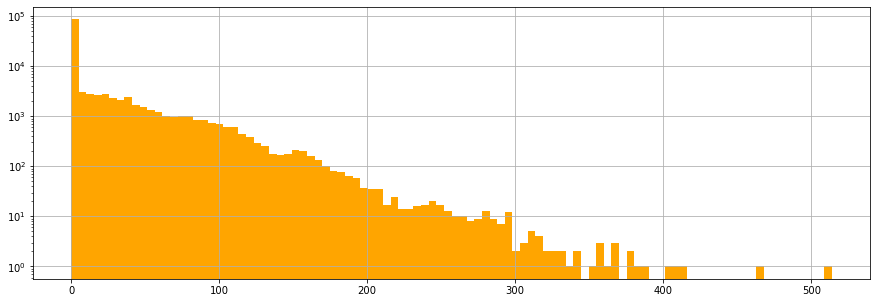

In [48]:
# переведем период владения в месяцы
x.fillna(0, inplace=True)
x['ownership'] = x.apply(lambda p: p.year * 12 + p.month, axis=1)

display(x.ownership.value_counts())
x.ownership.hist(figsize=(15,5), log=True, color='orange', bins=100);

# Заполним признак новыми данными
data.Владение = x.ownership.astype('int')

In [49]:
# если просто так оставить признак владения то результат даже немного ухудшается, поэтому разобьем его в виде 3 групп
def criteria(value):
    if value < 12:
        return 0 # плохо
    elif value < 24:
        return 1 # хорошо
    else: 
        return 2 # отлично
    
data.Владение = data.Владение.map(criteria)
display(data.Владение.value_counts())

0    90090
2    25471
1     6339
Name: Владение, dtype: int64

In [50]:
# def calc_delta_ouned(x):
#     if x['year'] > 0:
#         now = datetime.now()
#         return (now.year - x['year'])*12 - x['month'] + now.month
#     else: return 0

# df_xxx = pd.DataFrame(data.Владение)
# pattern = re.compile('\d{1,2}')
# # df_xxx['year'] = df_xxx.Владение.apply(lambda x:str(pattern.findall(str(x)))[2:-2])
# df_xxx['year'] = df_xxx.Владение.apply(lambda x:str(pattern.findall(str(x))))
# pattern = re.compile('(\d{1,2})\}$')
# df_xxx['month'] = df_xxx.Владение.apply(lambda x:str(pattern.findall(str(x)))[2:-2])

In [51]:
# 28) ПТС - флаг наличия ПТС
print('Пропуски:', data.ПТС.isna().sum())
display(data.ПТС.value_counts(dropna=False).to_dict())


display(data[data.ПТС.isna()])
# Тк пропуски встречаются не только в трейне - заменим медианой
# data = data[~data.vendor.isna()]
data.ПТС.fillna(data.ПТС.mode()[0], inplace=True)
data.ПТС = data.ПТС.astype("category")

Пропуски: 5


{'Оригинал': 102549, 'Дубликат': 19346, nan: 5}

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference
37859,внедорожник,TOYOTA,https://auto.ru/cars/used/sale/toyota/land_cru...,серебристый,{'id': '0'},"пригоняли для себя из германии, первый хозяин ...",3.0,170,"{'cruise-control': True, 'electro-window-back'...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,180000,2002,"{'code': 'LAND_CRUISER_PRADO', 'name': 'Land C...",LANDCRUISERPRADO,TOYOTA LAND CRUISER PRADO 120 SERIES,5,1.626704e+09,RUB,2006,1004225975,"{'id': '6395605', 'name': '120 Series', 'year_...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,JAPANESE,2 владельца,2,NaN,полный,Левый,Не требует ремонта,Растаможен,1208250.0,True,1,0,0,0,4
53578,хэтчбек,SKODA,https://auto.ru/cars/used/sale/skoda/fabia/100...,чёрный,{'id': '0'},"комплектация sport (трехспицевый руль, кожаный...",1.5,90,"{'mirrors-heat': True, 'electro-window-front':...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,35000,2007,"{'code': 'FABIA', 'name': 'Fabia', 'ru_name': ...",FABIA,SKODA FABIA II,5,1.626695e+09,RUB,2008,1001193366,"{'id': '2309161', 'name': 'II', 'ru_name': '2'...",HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,1 владелец,0,NaN,передний,Левый,Не требует ремонта,Растаможен,358000.0,True,0,0,0,0,1
71205,седан,AUDI,https://auto.ru/cars/used/sale/audi/80/1008159...,золотистый,{'id': '0'},торг,2.0,90,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,300000,1984,"{'code': '80', 'name': '80', 'ru_name': '80', ...",80,AUDI 80 IV (B3),4,1.626600e+09,RUB,1988,1008159427,"{'id': '7892649', 'name': 'IV (B3)', 'ru_name'...",SEDAN MECHANICAL 1.8,механическая,EUROPEAN,3 или более,2,NaN,передний,Левый,Не требует ремонта,Растаможен,89500.0,True,1,0,1,0,4
80569,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/3592562...,серебристый,{'id': '0'},"бмв 525е, 1983г, двигатель 2.7l, 125л.с. мотро...",2.5,120,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,200000,1984,"{'code': '5ER', 'name': '5 серии', 'ru_name': ...",5СЕРИИ,BMW 5 СЕРИИ II (E28) 525E,4,1.626608e+09,RUB,1988,35925626,"{'id': '3473276', 'name': 'II (E28)', 'ru_name...",SEDAN MECHANICAL 2.7,механическая,EUROPEAN,2 владельца,0,NaN,задний,Левый,Не требует ремонта,Растаможен,196900.0,True,1,0,0,0,4
97637,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/3350400...,синий,NaN,"сделано большое т.о. фильтра масляный, воздушн...",2.5,170,NaN,бензин,https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,276000,1998,"{""code"":""3ER"",""name"":""3 серии"",""ru_name"":""3 се...",3ER,323I 2.5 AT (170 Л.С.),4,1.603119e+09,RUB,1999,33504008,"{""id"":""6329491"",""name"":""323"",""nameplate"":""323i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,0,NaN,задний,Левый,Не требует ремонта,Растаможен,-1.0,False,0,0,0,0,1


In [52]:
# 29) Привод - тип привода
print('Пропуски:', data.Привод.isna().sum())
display(data.Привод.value_counts(dropna=False).to_dict())
data.Привод = data.Привод.astype("category")

Пропуски: 0


{'передний': 56354, 'полный': 52095, 'задний': 13451}

In [53]:
# 30) Руль - тип рулья
print('Пропуски:', data.Руль.isna().sum())
display(data.Руль.value_counts(dropna=False).to_dict())
data.Руль = data.Руль.astype("category")

Пропуски: 0


{'Левый': 114760, 'Правый': 7140}

In [54]:
# 31) Состояние - состояния автомобиля
print('Пропуски:', data.Состояние.isna().sum()) 
display(data.Состояние.value_counts(dropna=False).to_dict())
# data.Состояние = data.Состояние.astype("category")
display(data[data.Состояние.isna()])
# Тк пропуски встречаются только в трайне и признак принмает только одно значение - удалим признак 
delete_col.append('Состояние')

Пропуски: 4


{'Не требует ремонта': 121896, nan: 4}

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference
16889,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/gala...,фиолетовый,{'id': '0'},"не на ходу, двс после кап ремонта (2,4) инжект...",2.0,140,{},бензин,https://avatars.mds.yandex.net/get-verba/21620...,300000,1998,"{'code': 'GALANT', 'name': 'Galant', 'ru_name'...",GALANT,MITSUBISHI GALANT VIII РЕСТАЙЛИНГ,4,1.626672e+09,RUB,1998,1104581653,"{'id': '21364654', 'name': 'VIII Рестайлинг', ...",SEDAN MECHANICAL 2.0,механическая,JAPANESE,2 владельца,0,Оригинал,передний,Левый,NaN,Растаможен,53700.0,True,0,0,0,0,0
63305,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/camry/11...,чёрный,{'id': '0'},документы и авто продаются вместе с авто. авто...,3.5,280,"{'cruise-control': True, 'tinted-glass': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,160000,2006,"{'code': 'CAMRY', 'name': 'Camry', 'ru_name': ...",CAMRY,TOYOTA CAMRY VI (XV40),4,1.626699e+09,RUB,2006,1104606643,"{'id': '2309567', 'name': 'VI (XV40)', 'ru_nam...",SEDAN AUTOMATIC 3.5,автоматическая,JAPANESE,3 или более,2,Оригинал,передний,Левый,NaN,Растаможен,268500.0,True,1,0,0,0,0
63810,седан,AUDI,https://auto.ru/cars/used/sale/audi/a6/1104601...,чёрный,{'id': '0'},"продаю надежный, комфортабельный автомобиль au...",2.0,180,{'multizone-climate-control': True},бензин,https://autoru.naydex.net/AIOo9k096/4706b0sQt7...,63000,2011,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",A6,AUDI A6 IV (C7),4,1.626602e+09,RUB,2012,1104601198,"{'id': '6937659', 'name': 'IV (C7)', 'ru_name'...",SEDAN VARIATOR 2.0,вариатор,EUROPEAN,1 владелец,0,Оригинал,передний,Левый,NaN,Растаможен,890525.0,True,0,0,0,0,1
69752,седан,AUDI,https://auto.ru/cars/used/sale/audi/a6/1103464...,чёрный,{'id': '0'},продаю авто в хорошем состоянии.\nпередния под...,2.5,160,"{'engine-proof': True, 'cruise-control': True,...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,390000,1997,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",A6,AUDI A6 II (C5),4,1.626603e+09,RUB,2000,1103464792,"{'id': '3473237', 'name': 'II (C5)', 'ru_name'...",SEDAN AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,0,Дубликат,передний,Левый,NaN,Растаможен,196900.0,True,1,0,1,0,3


In [55]:
# 32) Таможня - флаг растаможки
print('Пропуски:', data.Таможня.isna().sum()) 
display(data.Таможня.value_counts(dropna=False).to_dict())
display(data[data.Таможня.isna()])
# Тк пропуски встречаются только в трайне и признак принмает только одно значение - удалим признак 
delete_col.append('Таможня')

Пропуски: 4


{'Растаможен': 121896, nan: 4}

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference
35387,лифтбек,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,{'id': '0'},"vоlkswagen роlo "") 2021 гoда bыпускa b hobом с...",1.5,110,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,2000,2020,"{'code': 'POLO', 'name': 'Polo', 'ru_name': 'П...",POLO,VOLKSWAGEN POLO VI,5,1.626712e+09,RUB,2021,1104238807,"{'id': '22163516', 'name': 'VI', 'ru_name': '6...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,0,Оригинал,передний,Левый,Не требует ремонта,NaN,1208250.0,True,1,1,1,0,1
38474,хэтчбек,TOYOTA,https://auto.ru/cars/used/sale/toyota/prius/11...,белый,{'id': '0'},абхазкие номера,2.0,100,"{'ptf': True, 'esp': True, 'drive-mode-sys': T...",гибрид,https://autoru.naydex.net/MgMy88H00/2e4ded1vP7...,150000,2009,"{'code': 'PRIUS', 'name': 'Prius', 'ru_name': ...",PRIUS,TOYOTA PRIUS III (XW30),5,1.626704e+09,RUB,2009,1104234777,"{'id': '5044577', 'name': 'III (XW30)', 'ru_na...",HATCHBACK_5_DOORS AUTOMATIC 1.8,автоматическая,JAPANESE,1 владелец,0,Дубликат,передний,Правый,Не требует ремонта,NaN,331150.0,True,1,0,0,0,0
61358,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/camry/11...,серый,{'id': '0'},машына нормальном состояний армянский учет,2.5,150,{},гибрид,https://avatars.mds.yandex.net/get-verba/10303...,200000,2009,"{'code': 'CAMRY', 'name': 'Camry', 'ru_name': ...",CAMRY,TOYOTA CAMRY VI (XV40) РЕСТАЙЛИНГ,4,1.626699e+09,RUB,2009,1104582069,"{'id': '4743242', 'name': 'VI (XV40) Рестайлин...",SEDAN VARIATOR 2.4,вариатор,JAPANESE,1 владелец,0,Оригинал,передний,Левый,Не требует ремонта,NaN,349050.0,True,1,0,0,0,0
82369,внедорожник,INFINITI,https://auto.ru/cars/used/sale/infiniti/qx70/1...,чёрный,{'id': '0'},автомобиль в хорошем техническом состоянии.экс...,3.0,240,"{'cruise-control': True, 'tinted-glass': True,...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,120000,2013,"{'code': 'QX70', 'name': 'QX70', 'ru_name': 'к...",QX70,INFINITI QX70,5,1.626654e+09,RUB,2013,1103614534,"{'id': '20182239', 'year_from': 2013, 'year_to...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,JAPANESE,1 владелец,0,Оригинал,полный,Левый,Не требует ремонта,NaN,1700500.0,True,1,0,0,0,0


In [56]:
# 33) price - цена
print('Пропуски:', data.price.isna().sum()) 
display(data.price.value_counts(dropna=False))

Пропуски: 0


-1.000          34686
 671250.000       912
 581750.000       901
 492250.000       850
 402750.000       837
                ...  
 424157.505         1
 1520336.500        1
 842195.000         1
 3893026.250        1
 294186.500         1
Name: price, Length: 6463, dtype: int64

# Feature engineering

In [57]:
# Создадим новые признаки
brand_dict = data[data.train].groupby(['brand'])['price'].count().to_dict()

# Доля бренда
data['brand_amount'] = data.brand.map(brand_dict)

brand_model_dict = data[data.train].groupby(['brand', 'model_name'])['price'].count().to_dict()

# Доля марки автомобиля
data['brand_model_amount'] = data[['brand', 'model_name']].apply(lambda p: brand_model_dict[(p.brand, p.model_name)], axis=1)

In [58]:
data_fe = data.drop(delete_col, axis=1) #создадим копию датасета и удалим ненужные признаки
data_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 121910
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   bodyType             121900 non-null  category
 1   brand                121900 non-null  category
 2   color                121900 non-null  category
 3   engineDisplacement   121900 non-null  float64 
 4   enginePower          121900 non-null  int64   
 5   fuelType             121900 non-null  category
 6   mileage              121900 non-null  int64   
 7   modelDate            121900 non-null  int64   
 8   model_name           121900 non-null  category
 9   numberOfDoors        121900 non-null  int64   
 10  productionDate       121900 non-null  int64   
 11  vehicleTransmission  121900 non-null  category
 12  vendor               121900 non-null  category
 13  Владельцы            121900 non-null  category
 14  Владение             121900 non-null  int64   
 15  

In [59]:
# Применим LabelEncoder ко всему набору категориальных признаков
label_encoder = LabelEncoder()
for column in data_fe.select_dtypes(include='category'):
    data_fe[column] = label_encoder.fit_transform(data_fe[column])

In [60]:
data_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121900 entries, 0 to 121910
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             121900 non-null  int64  
 1   brand                121900 non-null  int64  
 2   color                121900 non-null  int64  
 3   engineDisplacement   121900 non-null  float64
 4   enginePower          121900 non-null  int64  
 5   fuelType             121900 non-null  int64  
 6   mileage              121900 non-null  int64  
 7   modelDate            121900 non-null  int64  
 8   model_name           121900 non-null  int64  
 9   numberOfDoors        121900 non-null  int64  
 10  productionDate       121900 non-null  int64  
 11  vehicleTransmission  121900 non-null  int64  
 12  vendor               121900 non-null  int64  
 13  Владельцы            121900 non-null  int64  
 14  Владение             121900 non-null  int64  
 15  ПТС              

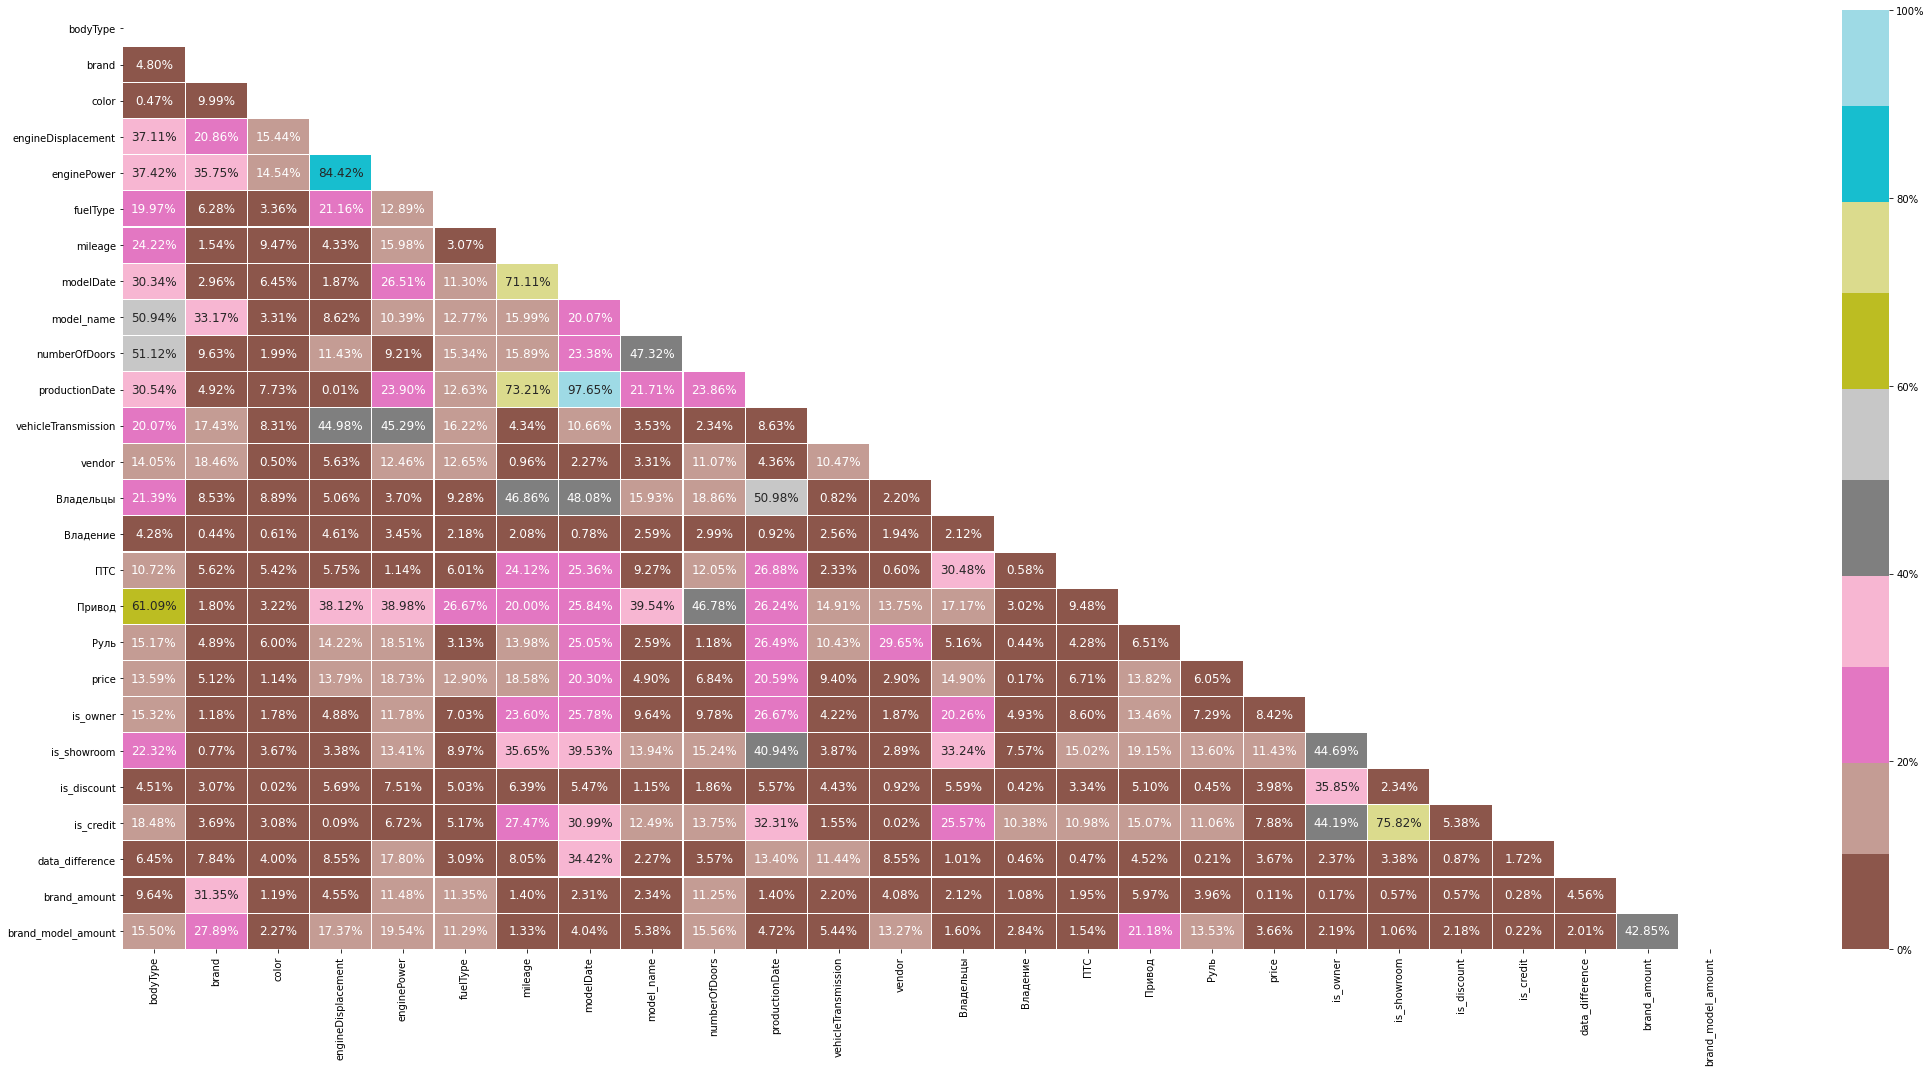

In [61]:
# Посмотрим на корреляцию Пирсона
heatmap_custom(data_fe[data_fe.train][[x for x in data_fe.columns if x not in ['train']]])

# Scaling

In [62]:
# Произведем маштабирование числовых признаков
# MinMaxScaler не искажает расстояния между значениями в каждой функции.
#согласное статье https://www.machinelearningmastery.ru/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02/

scaler = MinMaxScaler() 
# scaler = StandardScaler()
# scaler = RobustScaler()

scaler_features = data_fe.select_dtypes(include=['number']).columns
scaler_features = [x for x in scaler_features if x not in ['price']]

z = scaler.fit_transform(data_fe[data_fe.train][scaler_features])
data_fe.loc[data_fe.train, scaler_features] = scaler.fit_transform(data_fe[data_fe.train][scaler_features]) #.flatten()
data_fe.loc[~data_fe.train, scaler_features] = scaler.transform(data_fe[~data_fe.train][scaler_features]) # .flatten()
data_fe.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,train,is_owner,is_showroom,is_discount,is_credit,data_difference,brand_amount,brand_model_amount
102777,0.000000,0.454545,1.000000,0.363636,0.725,0.0,0.187234,0.861111,0.394595,1.000000,0.878788,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,-1.0,False,0.0,1.0,0.0,1.0,0.08,0.636364,-0.002035
67012,0.647059,0.000000,1.000000,0.181818,0.300,0.0,0.510638,0.638889,0.079279,0.666667,0.696970,0.333333,0.0,1.0,0.0,1.0,0.5,0.0,581750.0,True,1.0,0.0,0.0,0.0,0.16,0.545455,0.447270
88622,0.352941,0.727273,1.000000,0.181818,0.275,0.0,0.340426,0.666667,0.850450,1.000000,0.757576,0.000000,0.0,1.0,0.0,0.0,0.5,0.0,-1.0,False,0.0,0.0,0.0,0.0,0.20,0.363636,0.163106
16322,0.647059,0.545455,0.733333,0.181818,0.275,0.0,0.710638,0.222222,0.369369,0.666667,0.212121,0.666667,1.0,1.0,0.0,1.0,0.5,1.0,107400.0,True,1.0,0.0,0.0,0.0,0.12,0.454545,0.176670
39535,1.000000,0.909091,0.866667,0.090909,0.050,0.0,0.319149,0.194444,0.412613,0.333333,0.212121,0.666667,0.0,1.0,0.0,0.0,0.5,0.0,67125.0,True,1.0,0.0,1.0,0.0,0.16,0.909091,0.444218


In [63]:
# Попробуем создать новый признак на основе DBSCAN (Это не улучшает результат)
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.85, min_samples=35)

# y_pred = dbscan.fit_predict(data_fe.drop(['train', 'price'], axis=1))
# display(pd.Series(y_pred).value_counts())

# data_fe['DBSCAN'] = y_pred
# data_fe.sample(5)

# eps=0.8, min_samples=35
#  4    40400
#  0    27546
#  5     8230
#  1     5058
#  2     4370
#  3     1275
# -1      335

# eps=0.85, min_samples=30
#  4    40424
#  0    27586
#  5     8328
#  1     5074
#  2     4392
#  3     1299
# -1      111

# eps=0.85, min_samples=35
#  4    58455
#  0    38556
#  5    10904
#  1     6713
#  2     5435
#  3     1616
# -1      221

# Data Preprocessing

In [64]:
# заменим русские названия признаков на английские, тк некоторые алгоритмы машинного обучения понимают только английский
display(data_fe.columns)

data_fe.rename(columns={
    'Владельцы': 'owners',
    'Владение': 'ownership',
    'ПТС': 'vehiclePassport',
    'Привод' : 'driveCar',
    'Руль' : 'rudderType'
}, inplace=True)

display(data_fe.columns)

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы',
       'Владение', 'ПТС', 'Привод', 'Руль', 'price', 'train', 'is_owner',
       'is_showroom', 'is_discount', 'is_credit', 'data_difference',
       'brand_amount', 'brand_model_amount'],
      dtype='object')

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'owners',
       'ownership', 'vehiclePassport', 'driveCar', 'rudderType', 'price',
       'train', 'is_owner', 'is_showroom', 'is_discount', 'is_credit',
       'data_difference', 'brand_amount', 'brand_model_amount'],
      dtype='object')

In [65]:
train_df = data_fe[data_fe.train].drop(['train'], axis=1)
test_df = data_fe[~data_fe.train].drop(['train', 'price'], axis=1)

display(train_df.sample(5))
display(test_df.sample(5))

X = train_df.drop(['price'], axis=1)
y = train_df['price'] # <--- target

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,owners,ownership,vehiclePassport,driveCar,rudderType,price,is_owner,is_showroom,is_discount,is_credit,data_difference,brand_amount,brand_model_amount
40389,0.647059,0.909091,0.333333,0.090909,0.150,0.0,0.317021,0.722222,0.472072,0.666667,0.727273,0.000000,0.0,1.0,1.0,1.0,0.5,0.0,644400.0,1.0,0.0,0.0,0.0,0.08,0.909091,0.349271
69004,0.352941,0.000000,0.066667,0.363636,0.400,0.0,0.300000,0.722222,0.086486,1.000000,0.666667,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,1235100.0,1.0,0.0,0.0,0.0,0.00,0.545455,0.057986
32074,0.823529,0.909091,0.866667,0.090909,0.150,0.0,0.851064,0.333333,0.625225,1.000000,0.272727,0.666667,0.0,0.5,0.0,1.0,0.5,0.0,179000.0,1.0,0.0,1.0,0.0,0.04,0.909091,0.948457
58259,0.000000,0.818182,0.266667,0.636364,0.400,0.0,0.808511,0.305556,0.497297,1.000000,0.242424,0.666667,1.0,1.0,1.0,1.0,1.0,0.0,877100.0,0.0,0.0,0.0,0.0,0.04,1.000000,0.624958
52626,0.000000,0.727273,0.400000,0.090909,0.175,0.0,0.174468,0.805556,1.000000,1.000000,0.878788,0.666667,0.0,1.0,0.0,0.0,0.5,0.0,881575.0,0.0,1.0,1.0,1.0,0.16,0.363636,0.185487


,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,owners,ownership,vehiclePassport,driveCar,rudderType,is_owner,is_showroom,is_discount,is_credit,data_difference,brand_amount,brand_model_amount
114027,0.000000,0.545455,0.066667,0.363636,0.475,0.00,0.085106,0.861111,0.610811,1.000000,0.848485,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.04,0.454545,0.558155
105856,0.823529,0.454545,0.733333,0.181818,0.200,0.75,1.000000,0.555556,0.210811,1.000000,0.484848,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.00,0.636364,-0.002035
95653,0.647059,0.090909,0.800000,0.181818,0.250,0.00,0.531915,0.472222,0.036036,0.666667,0.454545,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.818182,-0.002035
109526,0.647059,0.818182,0.466667,0.090909,0.200,0.00,0.512766,0.611111,0.236036,0.666667,0.606061,0.666667,1.0,0.5,0.0,1.0,0.5,0.0,0.0,1.0,0.0,1.0,0.08,1.000000,0.811462
91182,0.647059,0.000000,0.866667,0.909091,1.000,0.00,0.344681,0.583333,0.088288,0.666667,0.545455,0.000000,0.0,0.5,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.04,0.545455,0.138352


## Feature elimination

In [66]:
# Значение метрики MAPE лучше, если признаки оставить (для модели CatBoostRegressor)
# поэтому признаки не удаляем, темболее на kaggle для этого часто не хватает памяти
feat_importances = X.columns
## отберем ненужные признаки с помощью случайного леса

# model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# model.fit(X, y)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh', figsize=(15,10), color=['orange']);
# plt.tight_layout()
# feat_importances = feat_importances.index

### Feature ranking with recursive feature elimination (RFE)

In [67]:
# Рекурсивное устранение признаков (RFE) основывается на повторяющемся конструировании модели и 
# выборе лучше всех или хуже всех выполняемого признака, отделения этого признака и повторения цикла с оставшимися. 
# Этот процесс применяется, пока в наборе данных не закончатся признаки. 
# Цель RFE заключается в отборе признаков посредством рекурсивного рассмотрения всё меньшего и меньшего их набора.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

is_RFE = False
if is_RFE:
    # После применение алгоритма половина признаков удалено, посмотрим как это повлияет на итоговый результат
    columns = feat_importances
    print(f'List columns old (len={len(columns)}):')
    display(pd.Series(columns))

    logreg = LogisticRegression()
    rfe = RFE(logreg,n_features_to_select=None)
    rfe = rfe.fit(X, y)
    # print(rfe.support_)
    # print(rfe.ranking_)

    columns_with_rfe=[value for (index, value) in enumerate(columns) if rfe.support_[index]]
    print(f'\nList columns with rfe (len={len(columns_with_rfe)}):')
    display(pd.Series(columns_with_rfe))
    feat_importances = columns_with_rfe
#     data_fe_with_dummies = data_fe_with_dummies[[*columns_with_rfe, *['default','train']]]

In [68]:
X = X[feat_importances]
test_df = test_df[feat_importances]

## Train Split

In [69]:
# Lazypredict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# Создадим флаг указывающий нужно ли применять к price логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp)
is_log_price = True

## Lazypredict

In [70]:
# Установка этой библиотеки ломает numpy из-за чего все ноутбуки перестают работать, а на
# kaggle для выполнения LazyRegressor не хватает памяти.
# Поэтому попробуем библиотеку pycaret



# pip install lazypredict

In [71]:
# https://lazypredict.readthedocs.io/en/latest/readme.html#regression
# from lazypredict.Supervised import LazyRegressor
# from sklearn import datasets
# from sklearn.utils import shuffle
# import numpy as np

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

## PYCARET

In [72]:
# install the full version of pycaret
# !pip install pycaret[full]
# pip install -q -r requirements.txt
#  !pip install pycaret[full] -q

In [73]:
# from pycaret.regression import *

# train_df_pycaret = train_df.copy()

# if is_log_price:
#     train_df_pycaret.price = np.log(train_df_pycaret.price)

# exp_name = setup(data=train_df_pycaret, target='price')

In [74]:
# top3 = compare_models(n_select = 3) # закоментируем, тк долго считает

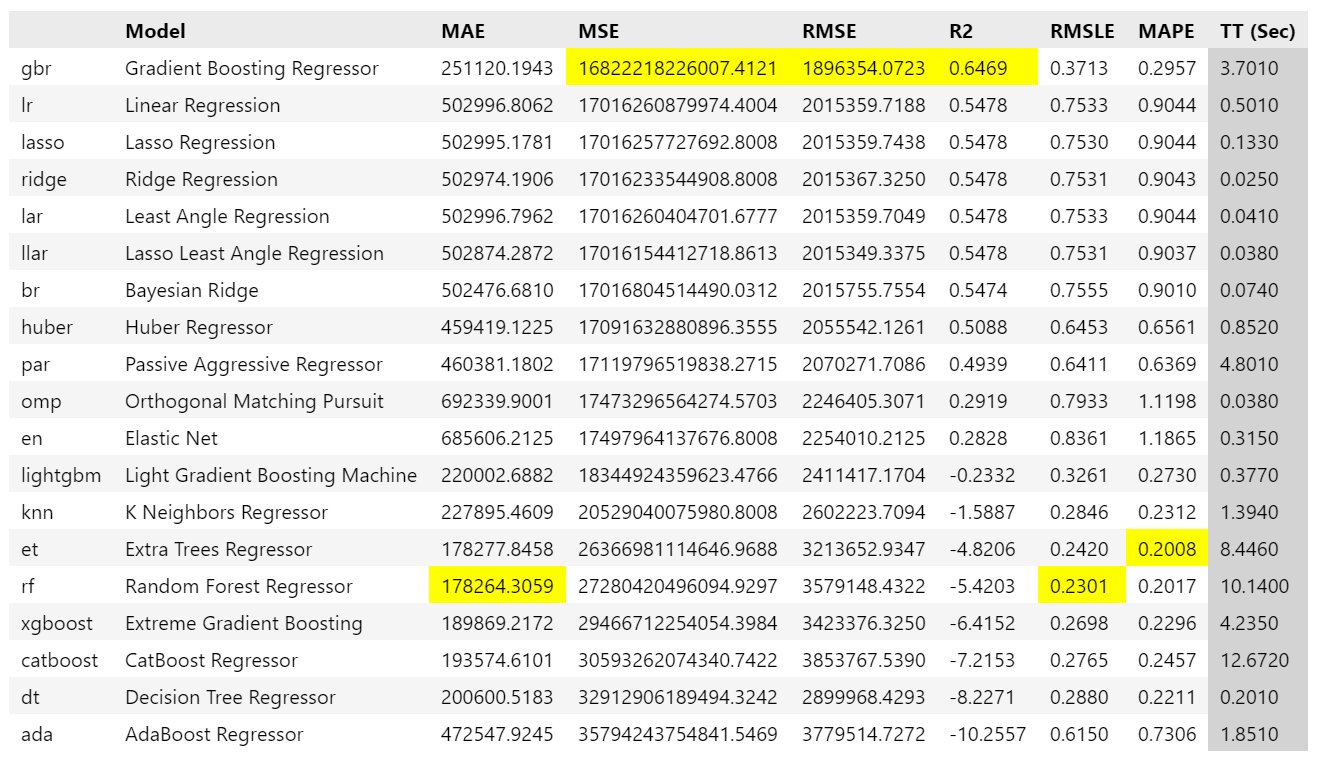

## Cоздадим и подберем гиперпараметры для лучших моделей
(на локальной машине и kaggle получаются немного разные модели)

### Gradient Boosting Regressor

In [75]:
# gbr = create_model('gbr') # Gradient Boosting Regressor
# predict_submission = get_predict_submission(gbr, X_test, y_test, test_df, is_log_price)
# 2021-07-24 14:05:04 точность модели по метрике MAPE: 19.62%
# 2021-07-27 14:01:53 точность модели по метрике MAPE: 19.54%

In [76]:
# tuned_lr = tune_model(gbr) # подбор лучших гиберпараметров
# predict_submission = get_predict_submission(tuned_lr, X_test, y_test, test_df, is_log_price)

# 2021-07-24 14:10:12 точность модели по метрике MAPE: 17.79%
# Your submission scored 20.16473, which is an improvement of your previous score of 20.21121. Great job!
# Gradient Boosting Regressor - c подобранными гипер параметрами дал лучший результат

# 2021-07-27 14:12:26 точность модели по метрике MAPE: 16.55%
# Your submission scored 24.57779, which is not an improvement of your best score. Keep trying!
# В этот раз дало намного худший результат

### Extra Tree Regressor

In [77]:
# et = create_model('et') # Extra Tree Regressor
# predict_submission = get_predict_submission(et, X_test, y_test, test_df, is_log_price)
# 2021-07-24 14:17:18 точность модели по метрике MAPE: 22.49%

In [78]:
# tuned_et = tune_model(et) # подбор лучших гиберпараметров
# predict_submission = get_predict_submission(tuned_et, X_test, y_test, test_df, is_log_price)
# На kaggle не отработала даже за 11 часов

### Random Forest Regressor

In [79]:
# rf = create_model('rf') # Random Forest Regressor
# predict_submission = get_predict_submission(rf, X_test, y_test, test_df, is_log_price)
# 2021-07-25 01:04:18 точность модели по метрике MAPE: 13.56%
# С виду хороший результат но в лидерборде 23.22742 (плохо)

In [80]:
# tuned_rf = tune_model(rf) # подбор лучших гиберпараметров
# predict_submission = get_predict_submission(tuned_rf, X_test, y_test, test_df, is_log_price)
# На kaggle не отработала

### Decision Tree Regressor

In [81]:
# dt = create_model('dt') # Decision Tree Regressor
# predict_submission = get_predict_submission(dt, X_test, y_test, test_df, is_log_price)
# 2021-07-25 01:54:14 точность модели по метрике MAPE: 24.70%
# в лидерборде 50.74287 - очень плохо, тюнить модель не будем.

### Light Gradient Boosting Machine

In [82]:
# lightgbm = create_model('lightgbm') # Light Gradient Boosting Machine Do not support non-ASCII characters in feature name.
# predict_submission = get_predict_submission(lightgbm, X_test, y_test, test_df, is_log_price)
# 2021-07-25 02:07:10 точность модели по метрике MAPE: 18.17%
# С виду хороший результат но в лидерборде 24.54098 (плохо), тюнить модель не будем.

## Bagging
> **Баггинг (bagging)** -это параллельный способ построения ансамбля. Коротко о способе построения: 
> 1. Обучающая выборка сэмплируется  раз с помощью bootstrap (выбор с возвращением).
> 1. На каждом сэмпле обучается отдельная базовая модель.
> 1. Ответы моделей усредняются (возможно, с весами).
> 
> Необходимость бэггинга может возникнуть тогда, когда вы уже нашли хорошую модель, и никак больше не можете повысить ее качество. В этом случае можно перейти к более продвинутой истории: использовать не одну модель (пусть и очень хорошую!), а ансамбли моделей. Под термином ансамбли понимается ряд продвинутых техник машинного обучения. Хотя он обычно применяется к методам дерева решений, его можно использовать с любым типом метода. Бэггинг - это частный случай метода усреднения модели

In [83]:
# creating a decision tree model
# dt = create_model('dt')
# # ensembling a trained dt model
# dt_bagged = ensemble_model(dt, method = 'Bagging')
# predict_submission = get_predict_submission(dt_bagged, X_test, y_test, test_df, is_log_price)
# 2021-07-25 02:16:23 точность модели по метрике MAPE: 14.93%
# С виду хороший результат но в лидерборде 24.00138 (плохо).

# Если подсунуть в качестве модели gbr то получится - 2021-07-25 02:26:04 точность модели по метрике MAPE: 19.50%

## Boosting
> **Бустинг (boosting)** — продвинутый метод построения ансамблей, где алгоритмы строятся итеративно, компенсируя ошибки предыдущих.

In [84]:
# dt = create_model('dt')
# # ensembling a trained dt model
# boosted_dt = ensemble_model(dt, method = 'Boosting', n_estimators = 100)
# predict_submission = get_predict_submission(boosted_dt, X_test, y_test, test_df, is_log_price)
# # 2021-07-25 02:33:40 точность модели по метрике MAPE: 13.42%
# # С виду хороший результат но в лидерборде 22.89283 (все равно плохо).


In [85]:
# Хотел попробовать перемешивание моделей, но не получилось
## Blend Models
# train a voting regressor on all models in library
# train a voting regressoron specific models
# dt = create_model('dt')
# rf = create_model('rf')
# adaboost = create_model('ada')

# blender_specific = blend_models(estimator_list = [dt, rf, adaboost])
# # train a voting regressor dynamically
# blender_specific = blend_models(estimator_list = compare_models(n_select = 5))
# predict_submission = get_predict_submission(blender_specific, X_test, y_test, test_df, is_log_price)

# Не может выполнится, пишет ошибку
# catboost/libs/data/model_dataset_compatibility.cpp:79: At position 12 should be feature with name owners (found vendor).

## Stacking
> **Стекинг (stacking)** — агрегация ответов моделей машинного обучения при помощи ещё одной модели машинного обучения. Подход использует понятие базовых моделей, каждая из которых обучается независимо от остальных, и мета-модели, которая использует предсказания базовых моделей как признаки.
>
>Правила стекинга:
> 1. Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается **data leak**, появляющийся при оценке алгоритмов на обучающей выборке.
> 1. Можно использовать подходы из **кросс-валидации** (разбиение по фолдам, бутстрап) для получения различных моделей.
> 1. Лучше применять **регрессоры** для мета-моделей.
> 1. Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют **блендингом** (blending).
> 1. Брать в качестве базовых моделей модели различной природы.
> 1. Обучать модель не только на истинный таргет, но и на **прокси таргет**, например, на важный признак, который выявили во время исследования данных.
> 1. Делать стекинг с большим количеством **уровней** при наличии достаточного количества данных, времени и усилий, что на практике редко.

In [86]:
# creating multiple models for multiple layer stacking
# catboost = create_model('catboost')
# et = create_model('et')
# lightgbm = create_model('lightgbm')
# xgboost = create_model('xgboost')
# ada = create_model('ada')
# rf = create_model('rf')
# gbr = create_model('gbr')

In [87]:
# tuned_lr = tune_model(gbr) # подбор лучших гиберпараметров
# predict_submission = get_predict_submission(tuned_lr, X_test, y_test, test_df, is_log_price)
# Gradient Boosting Regressor - c подобранными гипер параметрами дал лучший результат, поэтому перед стекингом затюним его

In [88]:
# creating multiple layer stacking from specific models
# stacker = stack_models(estimator_list=[lightgbm, xgboost, ada, et, catboost, rf], meta_model=gbr, verbose=False)

In [89]:
# Модель gbr както видо изменяиет столбцы в моделе, поэтому забьем костыль
# colunms_new=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'owners', 'driveCar', 'vendor_0.0', 'vehiclePassport_1.0', 'rudderType_1.0'] 
# # Сделаем копии датасетов и изменим имена столбцов
# X_test_copy = X_test.copy()
# X_test_copy.columns = colunms_new
# test_df_copy = test_df.copy()
# test_df_copy.columns = colunms_new

In [90]:
# predict_submission = get_predict_submission(stacker, X_test_copy, y_test, test_df_copy, is_log_price)
# predict_submission

# Тесты
# estimator_list=[lightgbm, xgboost, ada], meta_model=gbr
# 2021-07-25 06:49:23 точность модели по метрике MAPE: 17.53%
# С виду хороший результат но в лидерборде 24.93524 (все равно плохо).

In [91]:
start = datetime.now()
estimators = [('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                                   n_estimators=800,
                                                                   min_samples_split=5,
                                                                   min_samples_leaf=4,
                                                                   max_features='sqrt',
                                                                   max_depth=9),
                                         n_estimators=3,
                                         n_jobs=1,
                                         random_state=RANDOM_SEED)),
              ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                                       colsample_bytree=0.5,
                                       learning_rate=0.05,
                                       max_depth=12,
                                       alpha=1,
                                       n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators, final_estimator=CatBoostRegressor(iterations=5000,
                                                                                         random_seed=RANDOM_SEED,
                                                                                         eval_metric='MAPE',
                                                                                         custom_metric=['R2', 'MAE'],
                                                                                         silent=True,
                                                                                         learning_rate=0.13,
                                                                                         depth=12,
                                                                                         l2_leaf_reg=8,
                                                                                         random_strength=0.3))

# st_ensemble.fit(X_train, np.log(y_train) if is_log_price else y_train)
# predict_submission = get_predict_submission(st_ensemble, X_test, y_test, test_df, start)

# 2021-08-01 12:14:17 точность модели по метрике MAPE: 13.50%
# Your submission scored 21.02458, which is not an improvement of your best score. Keep trying!
# stacking очень долго считался и дал очень плохой результат в лидерборде 21.02458, 
# хотя на простом CatBoostRegressor я получил 20.11792. Поэтому стекинг пока не трогаем

# Наконец-то 0.90 смещение цены STACKING не улучшил результат!!!!
# 2021-08-01 14:12:12 точность модели по метрике MAPE: 13.64%
# Your submission scored 16.33901, which is not an improvement of your best score. Keep trying!

# 2021-08-02 05:08:30 точность модели по метрике MAPE: 13.59%
# Your submission scored 16.18385, which is not an improvement of your best score. Keep trying!
# Стекинг только ухудшатет метрику

## CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   

## Fit

In [92]:
# Найдем наилучшие параметры для CatBoostRegressor
# model =  CatBoostRegressor(#cat_features=cat_cols, 
#                           iterations=50
#                           ,loss_function='MAPE', metric_period=10)

# grid = {'learning_rate': [ 0.13, 0.14, 0.15]
#         ,'depth': [12]
#         ,'l2_leaf_reg': [7, 7.5, 8]
#         ,'random_strength': [0.3]}

# grid_search_result = model.grid_search(grid
#                                     ,X=X_train
#                                     ,y=np.log(y_train)
#                                     ,plot=True
#                                     ,verbose=False)
# print('\nВремя выполнения - ', datetime.now() - start)
# print('\nНаилучшие параметры: ', grid_search_result['params'])

# Время выполнения -  0:12:38.916049
# Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 8, 'random_strength': 0.3, 'learning_rate': 0.15}

In [93]:
start = datetime.now()
model1 = CatBoostRegressor(iterations = 1000, # 5000
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
#                           learning_rate=0.15, # эти параметры немного ухудшают результат
#                           depth=12,
#                           l2_leaf_reg=8, 
#                           random_strength=0.3
                          )
model1.fit(X_train, np.log(y_train) if is_log_price else y_train,
#          cat_features=data_fe.select_dtypes(include='category'),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
#          plot=True
         );

# оценим точность
predict_submission = get_predict_submission(model1, X_test, y_test, test_df, start)

####################---Лучшая позиция в лидерборде---#################
# смещение 0.895 , спрос отключен, место 64 но метрика немного выросла
# 2021-08-02 04:42:28 точность модели по метрике MAPE: 12.74%
# Your submission scored 15.36795, which is an improvement of your previous score of 15.45394. Great job!
######################################################################


# model1.save_model('catboost_single_model_2_baseline.model')


2021-08-02 07:48:53 точность модели по метрике MAPE: 12.89%


# Submission

In [100]:
sample_submission.loc[:].price = predict_submission
# sample_submission.loc[:, 'price'] = predict_submission
# sample_submission.price = predict_submission
sample_submission = sample_submission.astype('int')

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,665669
1,1100549428,993821
2,1100658222,944229
3,1100937408,767393
4,1101037972,739463
5,1100912634,807648
6,1101228730,677227
7,1100165896,424500
8,1100768262,1978280
9,1101218501,803160


# Conclusion
**Этапы работы над проектом**:
* Были спарсины свежие данные по всем маркам автомобилей с сайта avto.ru 
* Первичная обработка данных;
* Анализ распределения признаков. Замена пропусков;
* EDA
* Feature engineering;
* Корреляционный анализ;
* Отбор не коррелирующих переменных;
* Анализ признаков и устранение тех, которые не влияют на предсказываемую величину;
* Подбор параметров модели 
* Опробованы различные алгоритмы и библиотека ML - PyCaret
* Опробованы Ансамбль моделей: Blending, Bagging, Bosting, Stacking

Было создано достаточно много новых признаков, некоторые из которых имеют очень высокую корреляцию Пирсона. Тем не менее удаление сильно коррелируемых признаков в ручную или с помощью алгоритма RFE немного но ухудшало метрику, также у kaggle часто не хватает памяти на это. Поэтому данный шаг считаю можно отсавить на будущее, когда уже модель пойдет в продакш и будет важна ее скорость.

Среди всех опробованных мною алгоритмов и ансамблей моделей, наилучший результат в лидерборде дал CatBoostRegressor без подобранных параметров.

Так как обучающая и тестовая выборка были сделаны в разное время, для цены был применен поправочный кэффициент 0.895.
Точность модели по метрике MAPE: 12.74%, а в лидербоде удалось выбить **15.36795 (64 место)**.

Так же была применения идея вычисления спроса автомобилей у которых нет цены (проданы), идея хорошая но метрику она не улучшила.

In [586]:
# Даже на тюненой модели точность не сильно растет
# 2021-08-01 06:27:36 точность модели по метрике MAPE: 12.80%
# 2021-08-01 07:05:49 точность модели по метрике MAPE: 13.13%
# 2021-08-01 11:22:34 точность модели по метрике MAPE: 13.15%
# 2021-08-01 11:41:48 точность модели по метрике MAPE: 13.10%

# 2021-08-01 12:21:05 точность модели по метрике MAPE: 12.94%
# 2021-08-01 12:32:07 точность модели по метрике MAPE: 12.95%
# 2021-08-01 12:43:30 точность модели по метрике MAPE: 12.96%
# 2021-08-01 12:53:32 точность модели по метрике MAPE: 12.94%

# 2021-08-01 13:00:59 точность модели по метрике MAPE: 13.00%
# Your submission scored 20.21296, which is not an improvement of your best score. Keep trying!

# 2021-08-01 13:05:00 точность модели по метрике MAPE: 12.94%
# Your submission scored 20.24006, which is not an improvement of your best score. Keep trying!

# 2021-08-01 13:19:28 точность модели по метрике MAPE: 12.89%
# Your submission scored 21.08182, which is not an improvement of your best score. Keep trying!
# после введения признаков метрика стала лучше, но в лидерборде нет улучшений

# 2021-08-01 13:25:24 точность модели по метрике MAPE: 12.89%
# Your submission scored 21.08182, which is not an improvement of your best score. Keep trying!




# Наконец-то 0.96 смещение цены место 94
# 2021-08-01 13:34:07 точность модели по метрике MAPE: 12.89%
# Your submission scored 17.14838, which is an improvement of your previous score of 20.11792. Great job!


# Наконец-то 0.94 смещение цены место 80 место
# 2021-08-01 13:42:45 точность модели по метрике MAPE: 12.90%
# Your submission scored 16.31504, which is an improvement of your previous score of 17.14838. Great job!

# Наконец-то 0.90 смещение цены место 76 место
# 2021-08-01 13:47:13 точность модели по метрике MAPE: 12.91%
# Your submission scored 15.74993, which is an improvement of your previous score of 16.31504. Great job!

# Для самого лучшего результат поробую стекинг (проверил, стекинг не улучшил результат)

# смещение 0.91 цены место
# Your submission scored 15.94992, which is not an improvement of your best score. Keep trying!

# смещение 0.92 цены место
# Your submission scored 16.31504, which is not an improvement of your best score. Keep trying!

# смещение 0.905 цены место
# Your submission scored 15.71817, which is not an improvement of your best score. Keep trying!


# смещение 0.895 цены место 64
# Your submission scored 15.45394, which is an improvement of your previous score of 15.49252. Great job!


# 2021-08-01 08:30:46 точность модели по метрике MAPE: 13.19%
# Your submission scored 20.79694, which is not an improvement of your best score. Keep trying!
# сгруппировал некоторые признаки в other


# 2021-08-01 06:19:47 точность модели по метрике MAPE: 13.15%
# Your submission scored 20.81403, which is not an improvement of your best score. Keep trying!
# Тюненый catBoost ухудшил результат



#2021-08-01 06:00:49 точность модели по метрике MAPE: 12.80%
# Убрал признаки спроса и создал два признака и признака descriptiom        
# Your submission scored 20.21374, which is not an improvement of your best score. Keep trying!
# Снова нет улчшений

#2021-08-01 05:41:45 точность модели по метрике MAPE: 12.77%
# Добавил новые признаки спроса автомобилей (оставил только нормализованные признаки)
#Your submission scored 21.97753, which is not an improvement of your best score. Keep trying!
# Метрика вроде самая лучшая но в лидерборде не лучший результат!!!!

# 2021-08-01 05:29:46 точность модели по метрике MAPE: 12.78%
# Добавил новые признаки спроса автомобилей на основе статистики проданных авто
# Your submission scored 21.99858, which is not an improvement of your best score. Keep trying!
# Метрика вроде самая лучшая но в лидерборде не лучший результат!!!!

#2021-07-28 14:16:10 точность модели по метрике MAPE: 12.84%
# Обработал признак Владение разбил на 3 группы


# 2021-07-28 14:04:45 точность модели по метрике MAPE: 12.87%
# Обработал признак Владение

# 2021-07-27 13:50:49 точность модели по метрике MAPE: 12.83%
# Убрал лишние символы в model_name, улучшил результат 117 Sergey Pinaev 20.11792 !!!!


# 2021-07-24 08:39:54 точность модели по метрике MAPE: 12.89% 
# LabelEncoder - выключен, CatBoostRegressor - медлено работает

#2021-07-24 08:44:44 точность модели по метрике MAPE: 12.81% !!!
# LabelEncoder - включен, MinMaxScaler - выключен, CatBoostRegressor быстро работает

# 2021-07-24 08:48:38 точность модели по метрике MAPE: 12.81%
# LabelEncoder - включен, MinMaxScaler - включен (маштабирование не влияет на CatBoost), CatBoostRegressor быстро работает

# 2021-07-24 10:27:30 точность модели по метрике MAPE: 12.81%
# LabelEncoder - включен, MinMaxScaler - включен (маштабирование не влияет на CatBoost), DBSCAN - добавленный признак не улучшил результата

# 2021-07-24 14:10:12 точность модели по метрике MAPE: 17.79%
#Your submission scored 20.16473, which is an improvement of your previous score of 20.21121. Great job!

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing